# Memento analysis

## Background data

### Libraries and paths

In [1]:
import numpy as np
import scipy
from scipy import sparse
from scipy.sparse import csr_matrix
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import seaborn as sns
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata as ad
import glob
import sys
import memento
import gc
from statsmodels.stats.multitest import multipletests
import gseapy as gp

In [2]:
counts_file = '../../test/test123/write/qc_020725_raw.h5ad'

### Functions

In [3]:
# subset the adata object and format the .obs object for use with memento                                                                                                 
def format_memento(adata, ctypes, pops, conds, treatment_col):

    # subset to the cell types, populations, and conditions of interest                                                                                                   
    adata_sub = adata[(adata.obs['cell_label_coarse'] == ctypes) & \
                      (adata.obs['POP'].apply(lambda x: x in set(pops))) & \
                      (adata.obs['COND'].apply(lambda x: x in set(conds)))].to_memory()

    # add sequencing saturation data                                                                                                                                      
    adata_sub.seq_sat = adata_sub.obs['SEQ_SAT']

    adata_sub_obs = []

    # add individual data                                                                                                                                                 
    adata_sub_obs.append(pd.DataFrame({'ind': adata_sub.obs['ID'].cat.codes}))

    # add sex data                                                                                                                                                        
    adata_sub_obs.append(pd.DataFrame({'SEX': pd.get_dummies(adata_sub.obs[['SEX']], ['SEX'])['SEX_F'] \
                                       .apply(lambda x: int(x))}))

    # add age data                                                                                                                                                        
    adata_sub_obs.append(adata_sub.obs[['AGE']])

    # add batch data                                                                                                                                                      
    adata_sub_obs.append(pd.DataFrame({'batch': adata_sub.obs['lib_group'].apply(lambda x: int(x=="L5_L22"))}))

    # if there's more than one population, create dummy variable                                                                                                          
    if len(pops) > 1:
        adata_sub_obs.append(pd.DataFrame({treatment_col: pd.get_dummies(adata_sub.obs[['POP']], ['POP'])['POP_' + treatment_col] \
                                           .apply(lambda x: int(x))}))

    # if there's more than one population, create dummy variable                                                                                                          
    if len(conds) > 1:
        adata_sub_obs.append(pd.DataFrame({treatment_col: pd.get_dummies(adata_sub.obs[['COND']], ['COND'])['COND_' + treatment_col] \
                                           .apply(lambda x: int(x))}))

    # concatenate all of the obs data for the memento covariate table                                                                                                     
    adata_sub.obs = pd.concat(adata_sub_obs, axis=1)


    return(adata_sub)

In [8]:
def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

### Format data for Memento

In [4]:
adata = sc.read_h5ad(counts_file, backed='r')

In [5]:
# read in metrics and convert "Sequence Saturation" column to ratio
metrics = pd.read_csv("../../sample_info/10x.metrics_summary.all.csv", thousands=",")
metrics['Sequencing Saturation'] = metrics['Sequencing Saturation'].str.rstrip('%').astype('float') / 100.0

In [6]:
adata.obs['seq_sat'] = adata.obs[['library']].reset_index() \
    .merge(metrics[['LIB','Sequencing Saturation']], left_on='library', right_on='LIB') \
    .set_index('index').loc[adata.obs.index,'Sequencing Saturation']
adata.obs['capture_rate'] = adata.obs['seq_sat'] * 0.25

In [7]:
np.unique(adata.obs['cytopus_names'])

array(['B', 'CD4-T', 'CD8-T', 'DNT', 'M', 'MAIT', 'NK', 'Progenitor',
       'gdT'], dtype=object)

## Run Memento

### Test run

In [8]:
adata_test = adata[(adata.obs['cytopus_names']=="M") & \
    (adata.obs['COND']=="CTL") & \
    (adata.obs['Ethnicity'].isin(["Tikari","Fulani"]))].to_memory()

/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [13]:
sc.pp.highly_variable_genes(adata_test, flavor='seurat_v3', n_top_genes=5000)

In [16]:
adata_test = adata_test[:,adata_test.var['highly_variable']]

/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [18]:
adata_test.obs['Fulani'] = adata_test.obs['Ethnicity'].apply(lambda x: 0 if x == 'Tikari' else 1)

/tmp/ipykernel_137679/805701545.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_test.obs['Fulani'] = adata_test.obs['Ethnicity'].apply(lambda x: 0 if x == 'Tikari' else 1)


In [19]:
# set up memento
memento.setup_memento(adata_test, q_column='capture_rate')

In [20]:
# set up covariates
sample_meta = adata_test.obs[['TID','SEX','AGE','BATCH','Fulani']].drop_duplicates().set_index('TID')

In [21]:
# create covariates. Note that the 'F' is removed from the sex covariates but 
# no columns are removed from the batch covariates due to linear dependency. 
# Another option would be to remove a column from the batch and add an intercept term. 
# Because we aren't interest in intercept terms I'll leave as is.
batch = pd.get_dummies(sample_meta['BATCH'].astype('category'))
sex = pd.get_dummies(sample_meta['SEX'].astype('category'))
cov_df = sample_meta[['AGE']].merge(sex['M'], left_index=True, right_index=True) \
    .merge(batch, left_index=True, right_index=True)

In [22]:
cov_nobatch_df = sample_meta[['AGE']].merge(sex['M'], left_index=True, right_index=True)

In [23]:
pops = ['Tikari','Fulani']
test_pop = pops[pops != "Tikari"]
test_pop

'Fulani'

In [24]:
# fills the place of the "snps" dataframe
ethnicity_df = sample_meta[['Fulani']]

In [25]:
# fills the place of "gene_snp_pairs," will test "is Fulani" for every gene
gene_pop_pairs = pd.DataFrame({'gene': adata_test.var_names,
                               'SNP': "Fulani"})

In [33]:
np.max(adata_test.X)

3418.0

In [36]:
eqtl_results = memento.run_eqtl(
    adata=adata_test,
    snps=ethnicity_df,
    cov=cov_df,
    gene_snp_pairs=gene_pop_pairs,
    donor_column='TID',
    num_cpu=7,
    num_blocks=1, # increase this if you run out of memory.
    num_boot=25,
)

/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


blocksize 5000
working on block 0
3287


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    5.6s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    9.1s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:   14.9s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:   23.6s
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:   34.0s
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed:   46.7s
[Parallel(n_jobs=7)]: Done 2436 tasks      | elapsed:  1.0min
[Parallel(n_jobs=7)]: Done 3186 tasks      | elapsed:  1.3min
[Parallel(n_jobs=7)]: Done 3287 out of 3287 | elapsed:  1.4min finished


In [38]:
eqtl_results.sort_values('de_pval').head()

,gene,tx,de_coef,de_se,de_pval
0,MB21D2,Fulani,0.000144,0.000017,8.879975e-18
0,CTSD,Fulani,-0.000732,0.000102,3.633733e-13
0,ADTRP,Fulani,0.000033,0.000005,1.503000e-12
0,PTPRJ,Fulani,0.000488,0.000068,3.785749e-12
0,GPNMB,Fulani,-0.000341,0.000049,5.137738e-12


In [39]:
eqtl_results_nobatch = memento.run_eqtl(
    adata=adata_test,
    snps=ethnicity_df,
    cov=cov_nobatch_df,
    gene_snp_pairs=gene_pop_pairs,
    donor_column='TID',
    num_cpu=7,
    num_blocks=1, # increase this if you run out of memory.
    num_boot=25,
)

/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


blocksize 5000
working on block 0
3287


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  23 tasks      | elapsed:    1.9s
[Parallel(n_jobs=14)]: Done 214 tasks      | elapsed:    9.1s
[Parallel(n_jobs=14)]: Done 464 tasks      | elapsed:   14.8s
[Parallel(n_jobs=14)]: Done 814 tasks      | elapsed:   23.0s
[Parallel(n_jobs=14)]: Done 1264 tasks      | elapsed:   33.5s
[Parallel(n_jobs=14)]: Done 1814 tasks      | elapsed:   46.2s
[Parallel(n_jobs=14)]: Done 2464 tasks      | elapsed:  1.0min
[Parallel(n_jobs=14)]: Done 3214 tasks      | elapsed:  1.3min
[Parallel(n_jobs=14)]: Done 3287 out of 3287 | elapsed:  1.4min finished


In [41]:
eqtl_results_nobatch.sort_values('de_pval').head()

,gene,tx,de_coef,de_se,de_pval
0,HIST1H2AC,Fulani,0.000064,0.000009,2.968015e-12
0,OAS1,Fulani,-0.000070,0.000011,5.374571e-10
0,STAT1,Fulani,-0.000260,0.000039,1.023607e-09
0,TNFAIP8L3,Fulani,-0.000035,0.000006,1.213251e-09
0,TMTC1,Fulani,-0.000025,0.000004,1.759527e-08


In [49]:
eqtl_results_nocov = memento.run_eqtl(
    adata=adata_test,
    snps=ethnicity_df,
    cov=cov_nobatch_df.drop(['M'], axis=1),
    gene_snp_pairs=gene_pop_pairs,
    donor_column='TID',
    num_cpu=7,
    num_blocks=1, # increase this if you run out of memory.
    num_boot=25,
)

/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


blocksize 5000
working on block 0
3287


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    8.8s
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:   12.9s
[Parallel(n_jobs=14)]: Done 422 tasks      | elapsed:   18.7s
[Parallel(n_jobs=14)]: Done 772 tasks      | elapsed:   26.7s
[Parallel(n_jobs=14)]: Done 1222 tasks      | elapsed:   37.1s
[Parallel(n_jobs=14)]: Done 1772 tasks      | elapsed:   49.7s
[Parallel(n_jobs=14)]: Done 2422 tasks      | elapsed:  1.1min
[Parallel(n_jobs=14)]: Done 3172 tasks      | elapsed:  1.4min
[Parallel(n_jobs=14)]: Done 3287 out of 3287 | elapsed:  1.4min finished


In [ ]:
eqtl_results_nocov

### Test pipeline for DE between pops

In [82]:
ctypes = "M"
pops = ['Tikari', 'Fulani']
conds=['CTL']

In [89]:
adata_test = adata_ns[(adata_ns.obs['cytopus_names']==ctypes) &
                   (adata_ns.obs['Ethnicity'].isin(pops)) &
                   (adata_ns.obs['COND'].isin(conds))]

/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [90]:
test_pop = pops[1]

# set up covariates                                                                                                                                         
sample_meta = adata_test.obs[['TID','SEX','AGE','BATCH','Ethnicity']].drop_duplicates().set_index('TID')
sample_meta[test_pop] = sample_meta['Ethnicity'].apply(lambda x: 0 if x == pops[0] else 1)

batch = pd.get_dummies(sample_meta['BATCH'].astype('category'))                                                                                            
sex = pd.get_dummies(sample_meta['SEX'].astype('category'))
cov_df = sample_meta[['AGE']].merge(sex['M'], left_index=True, right_index=True) \
                             .merge(batch, left_index=True, right_index=True)

# fills the place of the "snps" dataframe                                                                                                                   
ethnicity_df = sample_meta[[test_pop]]

# fills the place of "gene_snp_pairs," will test "is Fulani" for every gene                                                                                 
gene_pop_pairs = pd.DataFrame({'gene': adata_test.var_names,
                               'SNP': test_pop})


# result_pop = memento.run_eqtl(
#     adata=adata_test,
#     snps=ethnicity_df,
#     cov=cov_df,
#     gene_snp_pairs=gene_pop_pairs,
#     donor_column='TID',
#     num_cpu=16,
#     num_blocks=1, # increase this if you run out of memory.                                                                                                 
#     num_boot=5000,
# )


In [91]:
ethnicity_df['Fulani'].value_counts()

Fulani
0    62
1    33
Name: count, dtype: int64

In [87]:
cov_df.head()

,AGE,M,EBT1,EBT5,EBT6,EBT7,EBT8,EBT9,EBT10,EBT20,...,NX25,NX27,NX28,NX29,NX41,WYJ1,WYJ2,WYJ3,WYJ4,WYJ5
TID,,,,,,,,,,,,,,,,,,,,,
NWD563279,63.0,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
NWD955353,82.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
NWD963823,50.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
NWD965754,33.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
NWD947647,35.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Analyze results

Questions to answer:

1) What are the pathways that are up- and down-regulated for each test?
2) Why are the cross pop comparisons wonky? I anticipate it's because the 'de_coef' means 'proportional increase in average expression' not 'log fold change'

In [3]:
de = pd.read_csv("../../test/test123/write/memento_results/memento.M.Tikari_Fulani.CTL.Ethnicity.csv", index_col=0)

In [4]:
de['nlt_pval'] = -np.log10(de['de_pval'])

<Axes: xlabel='de_coef', ylabel='nlt_pval'>

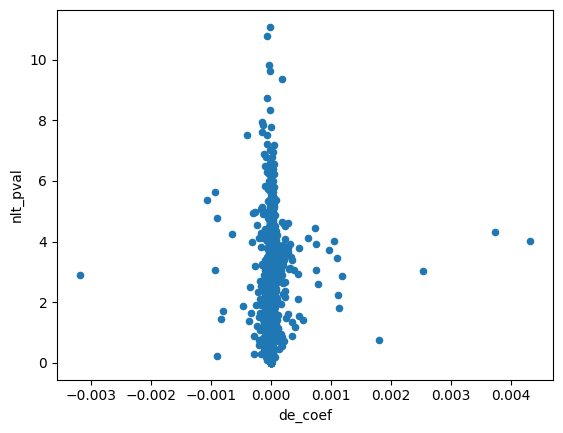

In [5]:
de.plot.scatter(x='de_coef', y='nlt_pval')

In [6]:
de.sort_values('de_coef')

,gene,tx,de_coef,de_se,de_pval,nlt_pval
0,FTL,Fulani,-0.003197,0.000998,0.001263,2.898518
0,S100A6,Fulani,-0.001074,0.000233,0.000004,5.380222
0,VIM,Fulani,-0.000942,0.000280,0.000893,3.049322
0,B2M,Fulani,-0.000931,0.000199,0.000002,5.649831
0,LGALS3,Fulani,-0.000906,0.000208,0.000017,4.775853
...,...,...,...,...,...,...
0,SERPINB2,Fulani,0.001181,0.000362,0.001413,2.849720
0,FTH1,Fulani,0.001802,0.001310,0.171352,0.766110
0,CXCL5,Fulani,0.002530,0.000761,0.000957,3.019283
0,IL1B,Fulani,0.003740,0.000904,0.000049,4.306516


In [7]:
# read in adata and calculate average 
adata = sc.read_h5ad(counts_file)

In [9]:
adata

AnnData object with n_obs × n_vars = 2416314 × 36601
    obs: 'donor_id', 'library', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'log10_total_counts', 'doublet_score', 'predicted_doublet', 'FID', 'LID', 'TID', 'COHORT', 'COND', 'SEX', 'AGE', 'POP', 'Ethnicity', 'FCluster_names', 'Cluster_names', 'SCluster_names', 'cytopus_names', 'BATCH'

In [10]:
cc_means = grouped_obs_mean(adata, ['cytopus_names','COND'])

/tmp/ipykernel_5389/1302019431.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata.obs.groupby(group_key)
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [17]:
cc_means.columns

Index([         ('B', 'CTL'),          ('B', 'IFN'),          ('B', 'LPS'),
            ('CD4-T', 'CTL'),      ('CD4-T', 'IFN'),      ('CD4-T', 'LPS'),
            ('CD8-T', 'CTL'),      ('CD8-T', 'IFN'),      ('CD8-T', 'LPS'),
              ('DNT', 'CTL'),        ('DNT', 'IFN'),        ('DNT', 'LPS'),
                ('M', 'CTL'),          ('M', 'IFN'),          ('M', 'LPS'),
             ('MAIT', 'CTL'),       ('MAIT', 'IFN'),       ('MAIT', 'LPS'),
               ('NK', 'CTL'),         ('NK', 'IFN'),         ('NK', 'LPS'),
       ('Progenitor', 'CTL'), ('Progenitor', 'IFN'), ('Progenitor', 'LPS'),
              ('gdT', 'CTL'),        ('gdT', 'IFN'),        ('gdT', 'LPS')],
      dtype='object')

In [22]:
cc_means.index

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=36601)

In [32]:
de_means = cc_means[[('M', 'CTL')]].reset_index(names='gene').merge(de)

In [33]:
de_means['de_coef_norm'] = de_means['de_coef']/de_means[('M', 'CTL')]

<Axes: xlabel='de_coef_norm', ylabel='nlt_pval'>

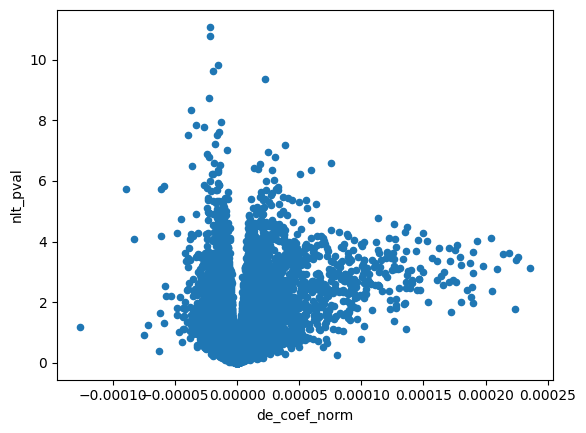

In [34]:
de_means.plot.scatter(x='de_coef_norm', y='nlt_pval')

In [40]:
de_means.sort_values('de_pval').head()

,gene,"(M, CTL)",tx,de_coef,de_se,de_pval,nlt_pval,de_coef_norm
15802,MPP1,1.130144,Fulani,-0.000025,0.000004,8.196935e-12,11.086349,-0.000022
14501,CST3,3.016397,Fulani,-0.000065,0.000010,1.645227e-11,10.783774,-0.000022
10103,DNAJC15,2.528687,Fulani,-0.000038,0.000006,1.518182e-10,9.818676,-0.000015
13851,IGFLR1,1.282760,Fulani,-0.000025,0.000004,2.349012e-10,9.629115,-0.000019
8509,PTPRJ,7.694387,Fulani,0.000175,0.000028,4.270272e-10,9.369544,0.000023


### Separate individuals sampled in Sabga in June and save file

Note that I had previously removed all Fulani sampled in Sabga in June, but only 3 of the 4 days show the potential contamination issue. I should also include the individuals from the fourth day.

In [3]:
adata = sc.read_h5ad(counts_file, backed='r')

In [4]:
sample_info_raw = pd.read_csv("/project/tishkofflab/data/Electronic_Field_Data/2024/2024_freeze_3/TishkoffLab/Collection_Demographics/Subject_Data.TishkoffLab.Collection_Demographics.2024_freeze_3.utf8.txt", sep="\t")

/tmp/ipykernel_122046/2890477736.py:1: DtypeWarning: Columns (4,5,6,9,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,52,53,54,55,56,57,58,59,60,61,62,63,64,65,67,68,69,71,72,74,75,77,78,80,81,83,84,86,87,89,90,92,93,95,96,98,99,101,102,104,105,107,108,110,111,113,114,116,117,119,120,122,123,125,126,128,129,130,131,132,133,134,135,136,165,166,167,168,169,170,171,172,173,174,175,176,177,180,181,182,183,185,187,189,191,192,193,194,195,196,197,198,199,200,201,202,203,204) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_info_raw = pd.read_csv("/project/tishkofflab/data/Electronic_Field_Data/2024/2024_freeze_3/TishkoffLab/Collection_Demographics/Subject_Data.TishkoffLab.Collection_Demographics.2024_freeze_3.utf8.txt", sep="\t")


In [5]:
site_collect = sample_info_raw[['ID:topmed',
                                'ID:field',
                                'Subject_Information:Ethnicity::str',
                                'Collection_Information:Latitude::num::deg',
                                'Collection_Information:Longitude::num::deg',
                                'Collection_Information:Site::str',
                                'Collection_Information:Date::date',
                                'Categorization:Lifestyle:Subsistence_Practice::str',
                                'Categorization:Lifestyle:Subsistence_Practice:Notes::str']]

site_collect = site_collect.rename(columns={'ID:topmed': 'TID',
                                            'ID:field': 'FID',
                                            'Subject_Information:Ethnicity::str': 'Ethnicity',
                                            'Collection_Information:Latitude::num::deg': 'latitude',
                                            'Collection_Information:Longitude::num::deg': 'longitude',
                                            'Collection_Information:Site::str': 'site',
                                            'Collection_Information:Date::date': 'date',
                                            'Categorization:Lifestyle:Subsistence_Practice::str': 'subsistence'})

In [6]:
contam_dates = ["2015-06-14 00:00:00", "2015-06-15 00:00:00", "2015-06-16 00:00:00"]

In [7]:
adata.obs[['site','date']] = adata.obs[['FID']].reset_index().merge(site_collect[['FID','site','date']]).set_index('index')[['site','date']]
adata.obs['Sabga_June'] = pd.Series((adata.obs['site']=="Sabga") & 
                                    (adata.obs['date'].isin(contam_dates)), dtype='category')

In [12]:
samp_dates = adata.obs[['FID','TID','date']].drop_duplicates()

In [17]:
samp_dates[samp_dates['date'].isin(contam_dates)][['FID','TID']].to_csv("../../misc/possible_contam_ids.scrnaseq.tsv", sep="\t", index=False)

In [10]:
adata_ns = adata[adata.obs['Sabga_June']==False]

/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [13]:
adata_ns = adata_ns.to_memory()

In [14]:
adata_ns.write("data/qc_020725_raw.nsj.h5ad")

In [68]:
np.max(adata_ns.X)

12477.0

In [69]:
adata_ns

AnnData object with n_obs × n_vars = 1993027 × 36601
    obs: 'donor_id', 'library', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'log10_total_counts', 'doublet_score', 'predicted_doublet', 'FID', 'LID', 'TID', 'COHORT', 'COND', 'SEX', 'AGE', 'POP', 'Ethnicity', 'FCluster_names', 'Cluster_names', 'SCluster_names', 'cytopus_names', 'BATCH', 'site', 'date', 'Sabga_June'

### Explore filtered results

#### Between conditions

/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


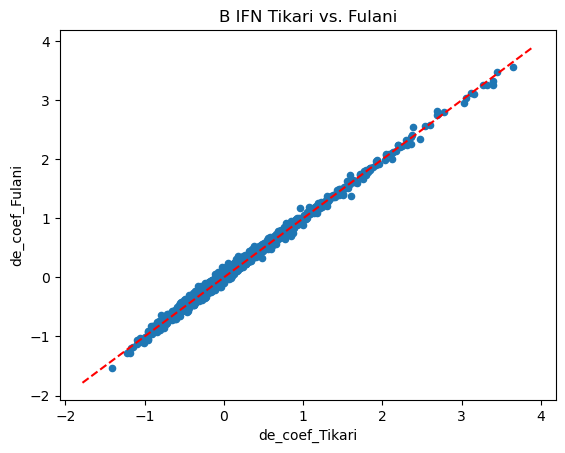

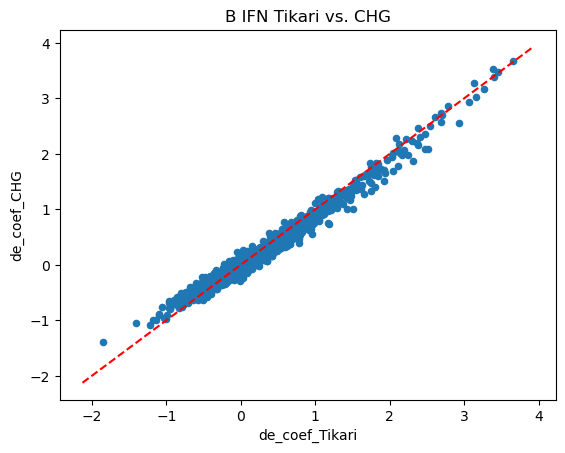

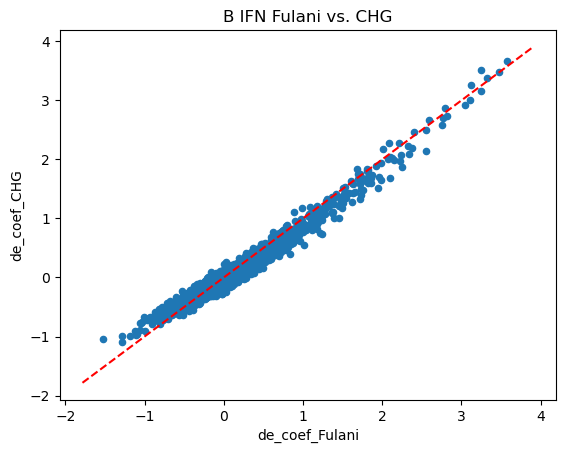

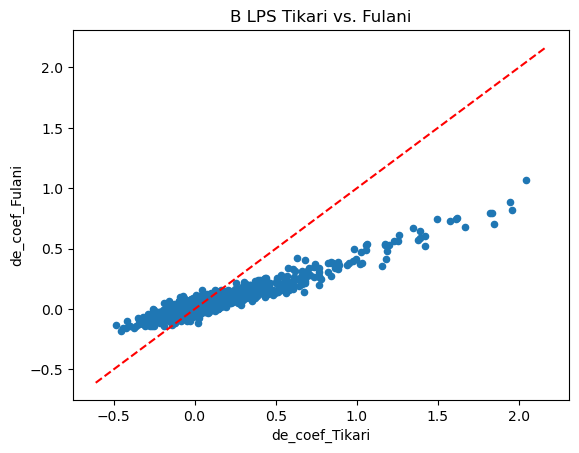

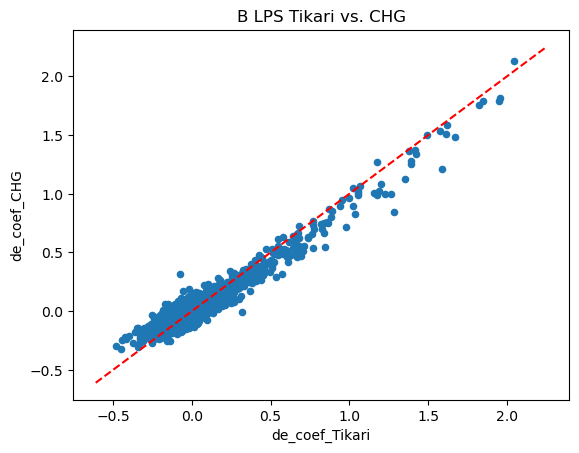

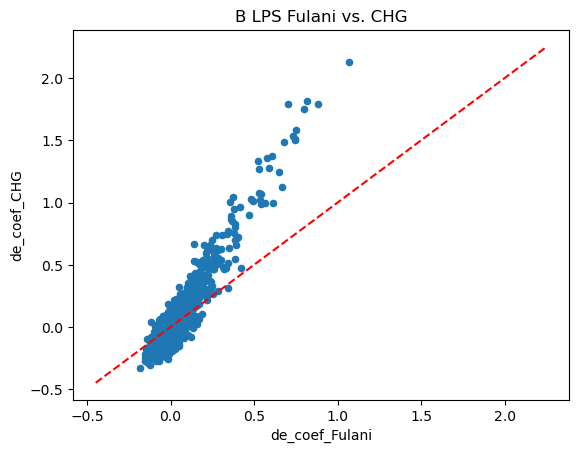

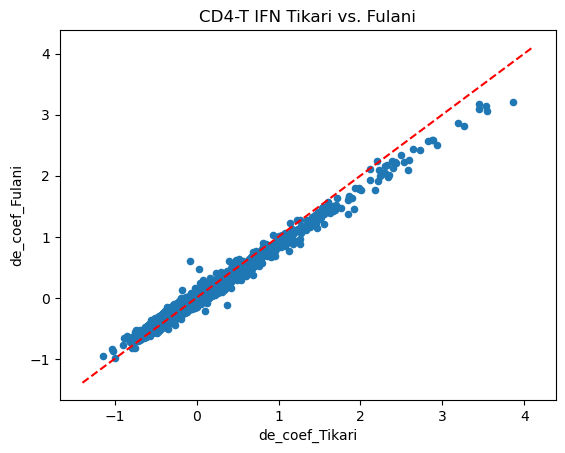

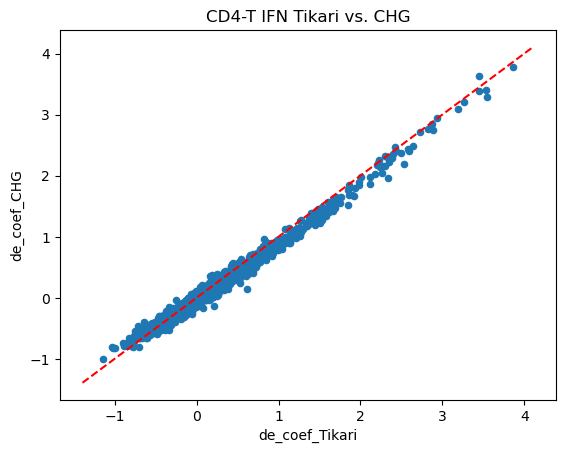

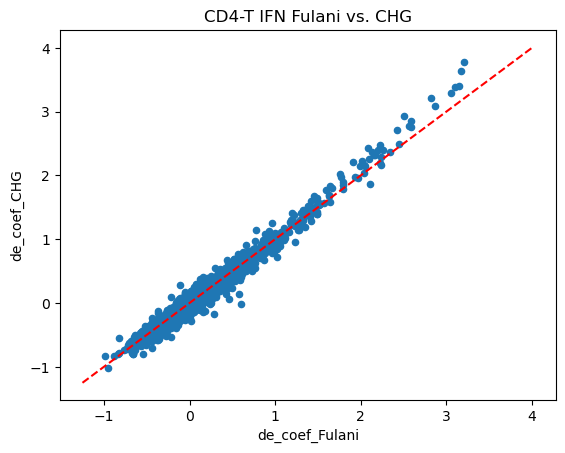

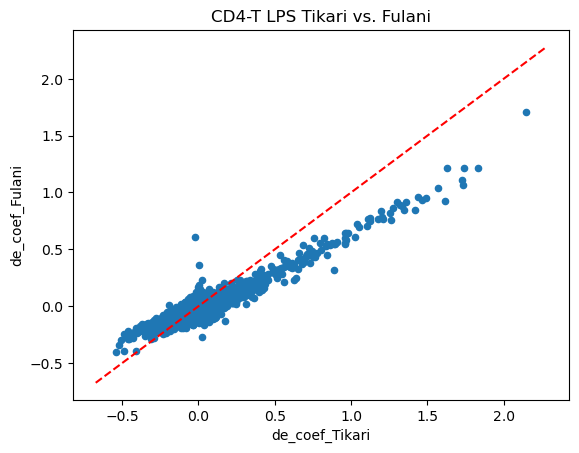

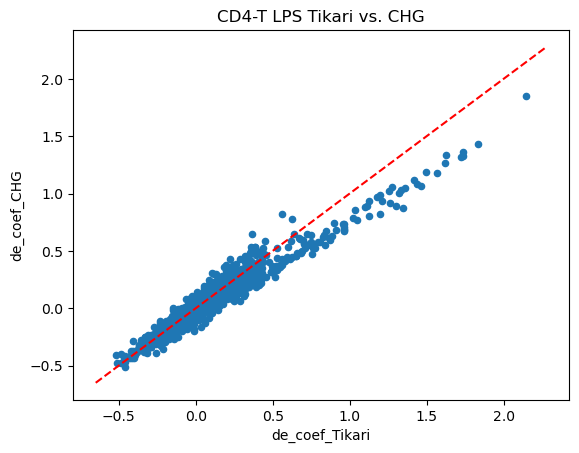

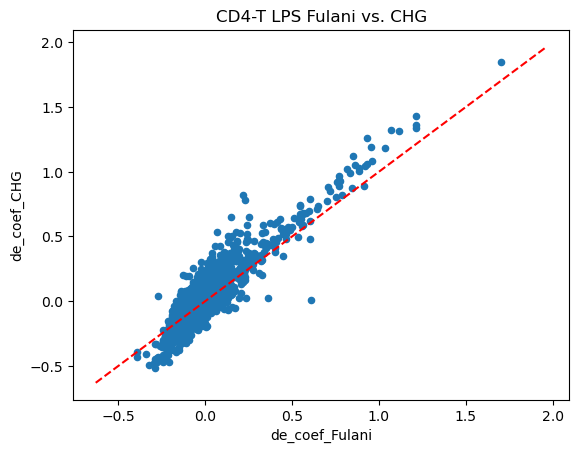

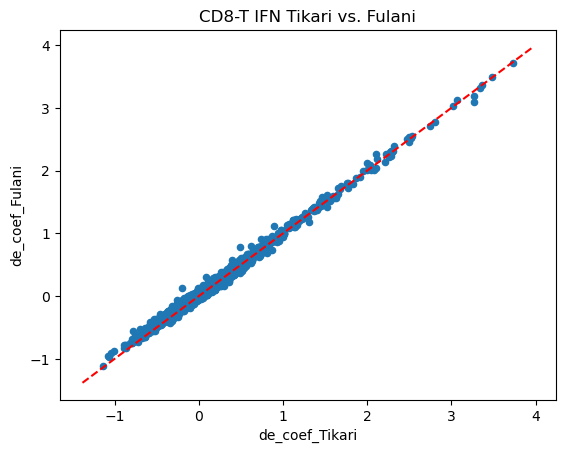

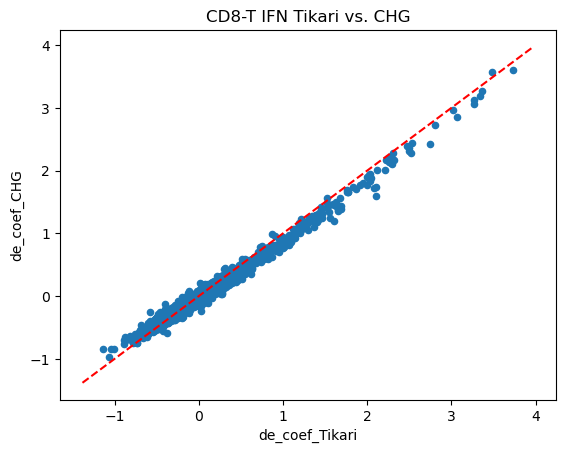

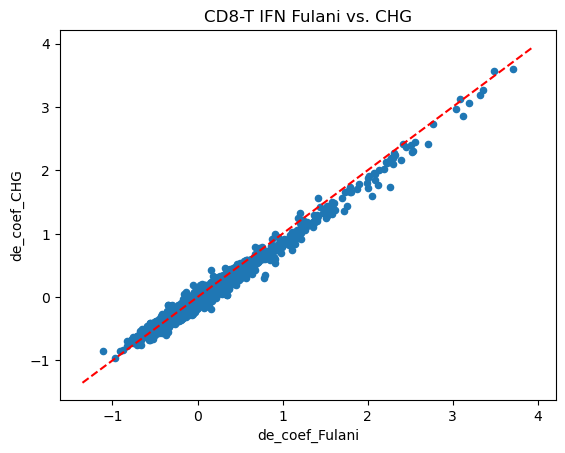

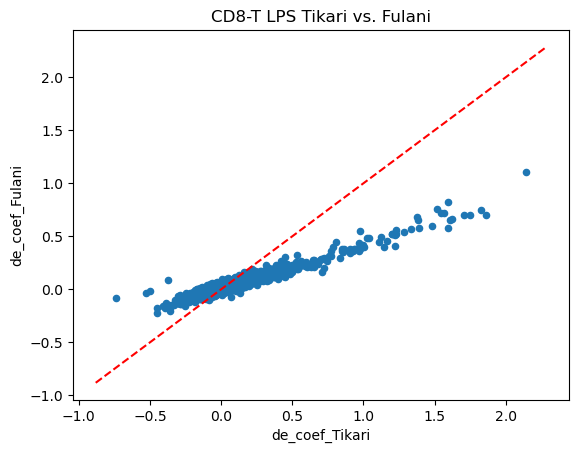

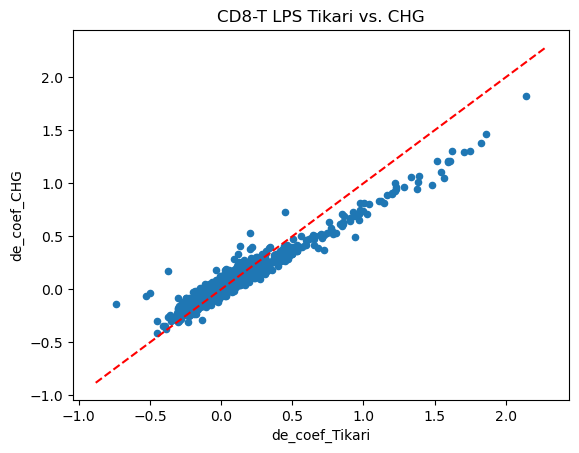

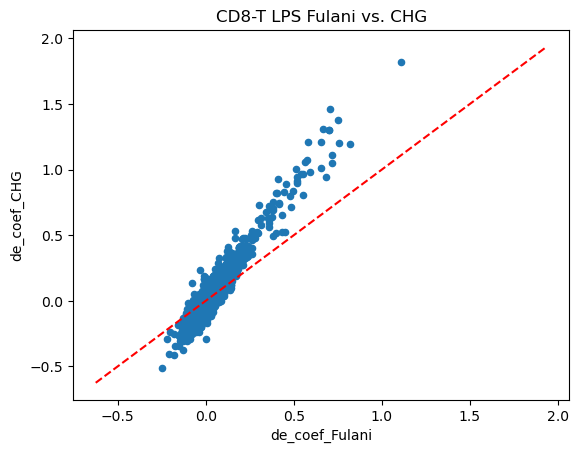

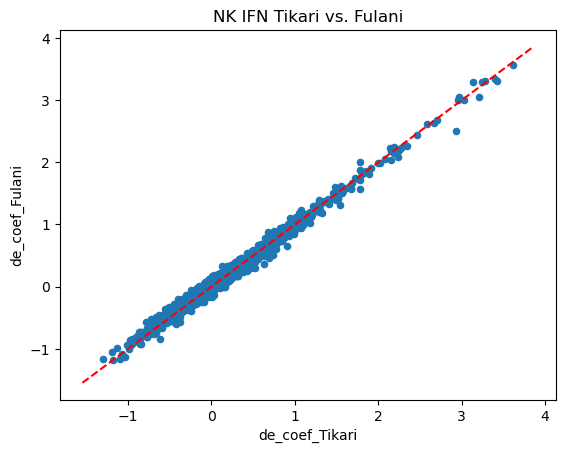

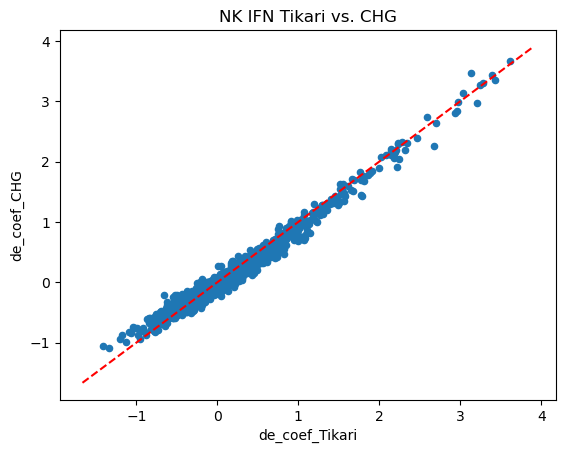

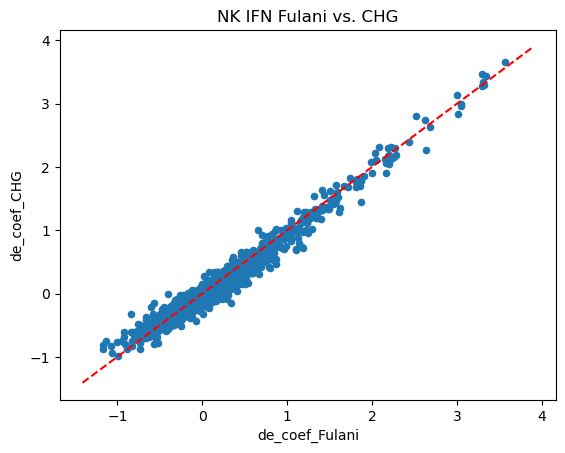

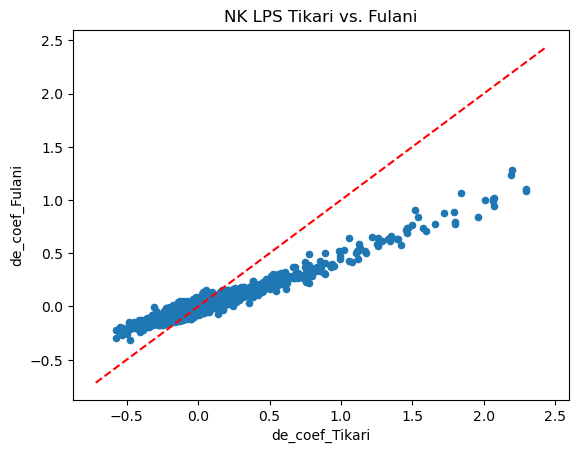

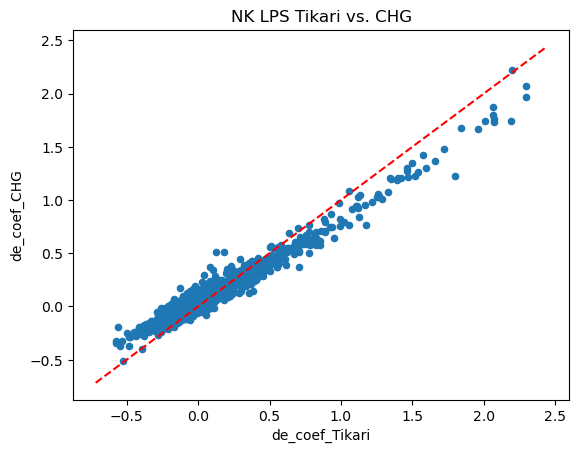

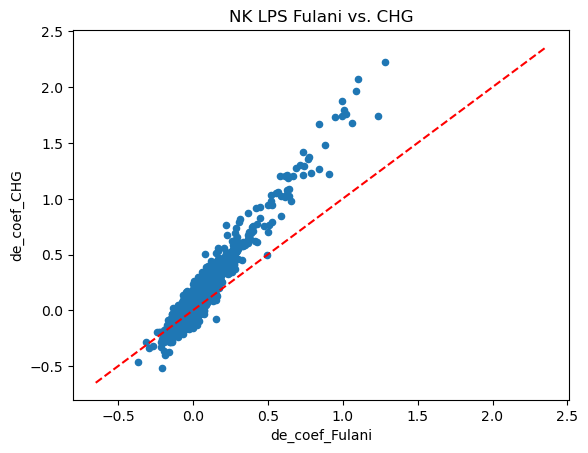

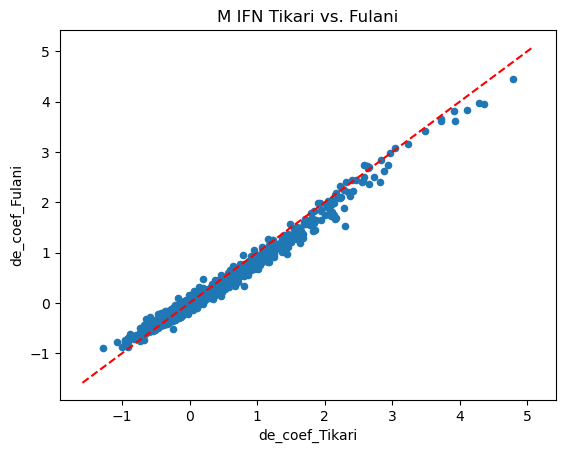

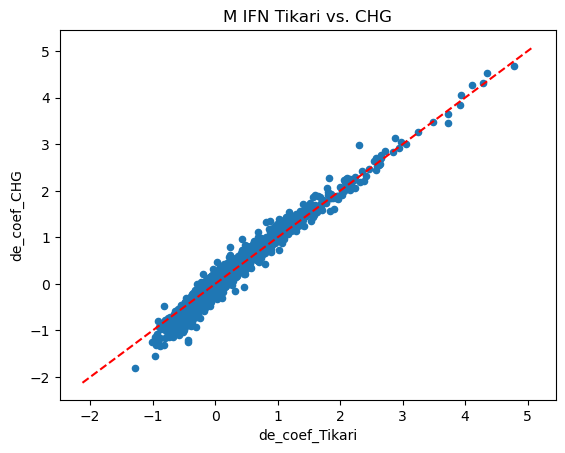

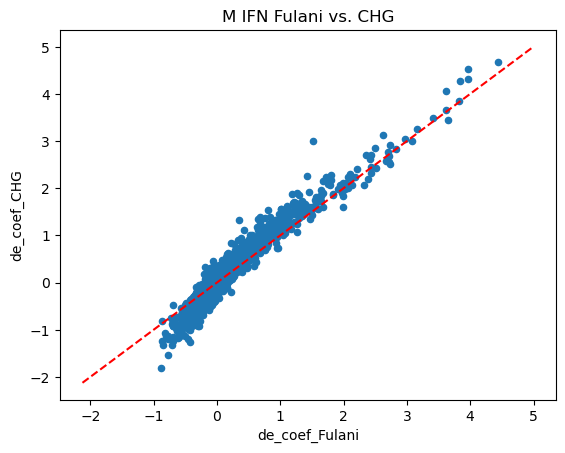

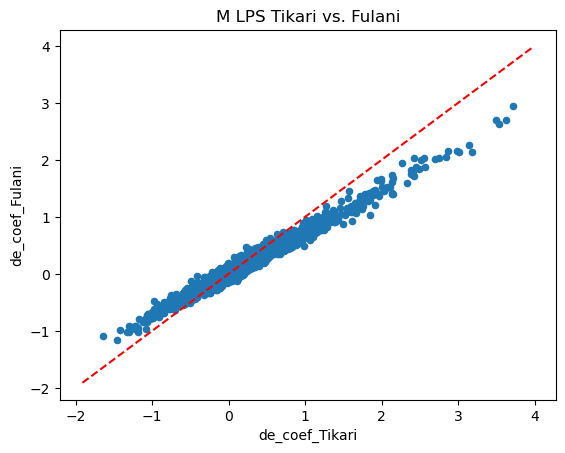

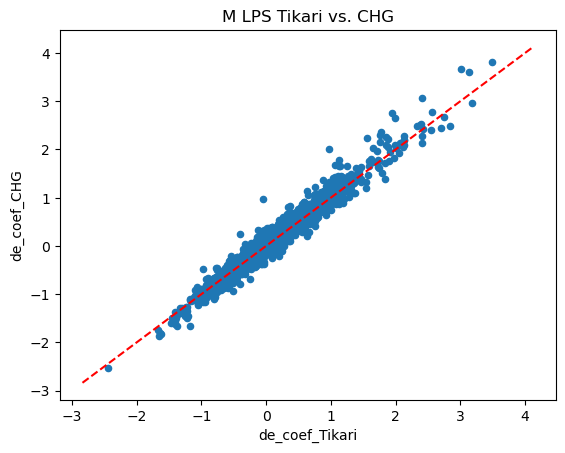

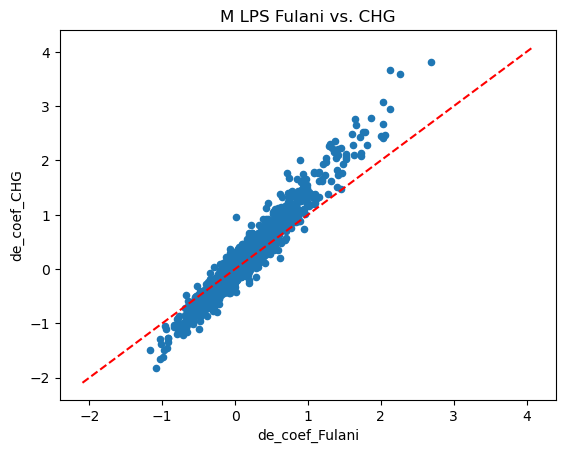

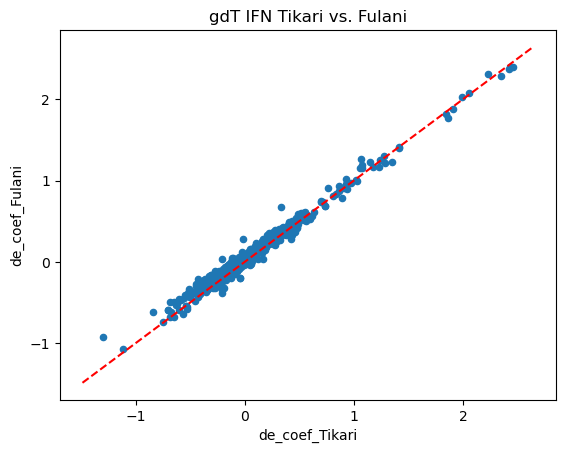

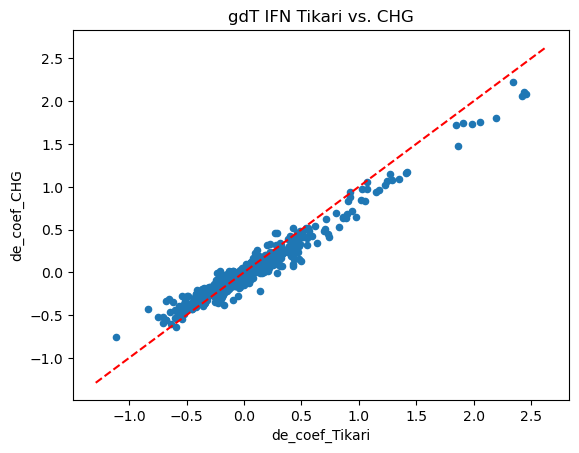

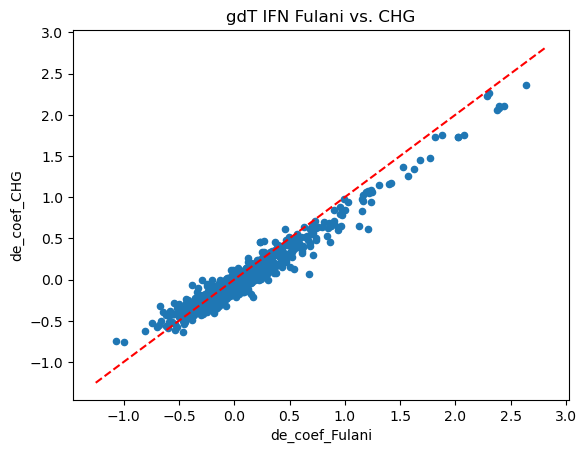

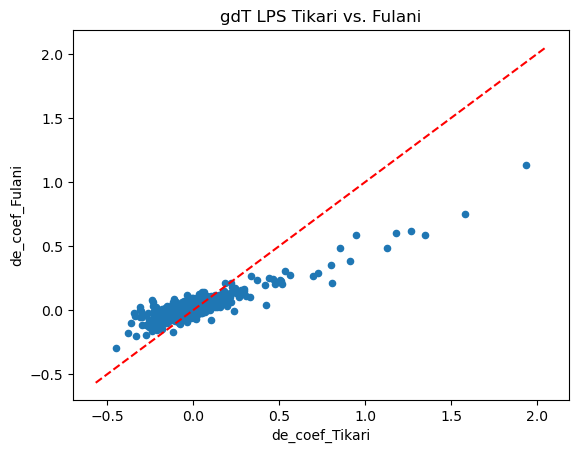

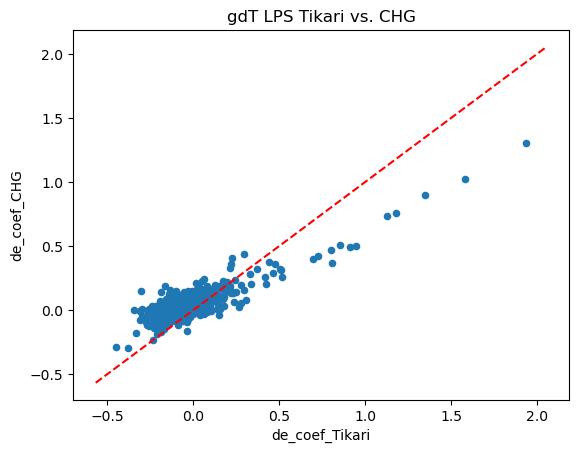

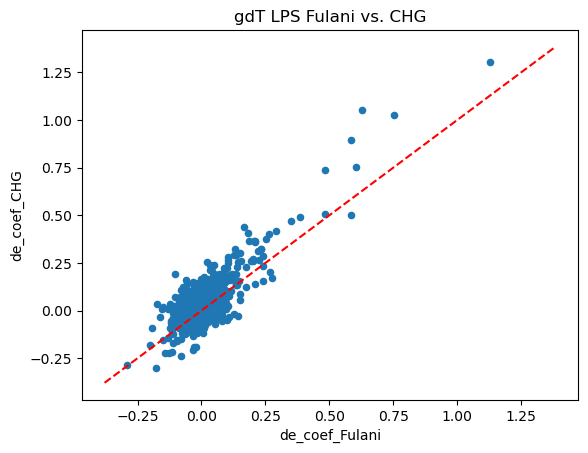

In [23]:
ctypes = ['B','CD4-T','CD8-T','NK','M','gdT']
#ctypes = ['B','CD4-T','NK','M','gdT']
for ctype in ctypes:
    
    for cond in ["IFN","LPS"]:
    
        results_t = pd.read_csv("output/memento.{}.Tikari.CTL_{}.COND.csv".format(ctype,cond), index_col=0)
        results_f = pd.read_csv("output/memento.{}.Fulani.CTL_{}.COND.csv".format(ctype,cond), index_col=0)
        results_c = pd.read_csv("output/memento.{}.CHG.CTL_{}.COND.csv".format(ctype,cond), index_col=0)

        results_tf = results_t[['gene','de_coef']].rename(columns={'de_coef': 'de_coef_Tikari'}) \
            .merge(results_f[['gene','de_coef']].rename(columns={'de_coef': 'de_coef_Fulani'}))
        results_tc = results_t[['gene','de_coef']].rename(columns={'de_coef': 'de_coef_Tikari'}) \
            .merge(results_c[['gene','de_coef']].rename(columns={'de_coef': 'de_coef_CHG'}))
        results_fc = results_f[['gene','de_coef']].rename(columns={'de_coef': 'de_coef_Fulani'}) \
            .merge(results_c[['gene','de_coef']].rename(columns={'de_coef': 'de_coef_CHG'}))

        results_tf.plot.scatter(x = 'de_coef_Tikari', y='de_coef_Fulani')
        plt.title("{} {} Tikari vs. Fulani".format(ctype,cond))
        xlims = plt.xlim()
        ylims = plt.ylim()
        min_limit = min(xlims[0], ylims[0])
        max_limit = max(xlims[1], ylims[1])
        plt.plot([min_limit, max_limit], [min_limit, max_limit], color='red', linestyle='--')
        
        results_tc.plot.scatter(x = 'de_coef_Tikari', y='de_coef_CHG')
        plt.title("{} {} Tikari vs. CHG".format(ctype,cond))
        xlims = plt.xlim()
        ylims = plt.ylim()
        min_limit = min(xlims[0], ylims[0])
        max_limit = max(xlims[1], ylims[1])
        plt.plot([min_limit, max_limit], [min_limit, max_limit], color='red', linestyle='--')
        
        results_fc.plot.scatter(x = 'de_coef_Fulani', y='de_coef_CHG')
        plt.title("{} {} Fulani vs. CHG".format(ctype,cond))
        xlims = plt.xlim()
        ylims = plt.ylim()
        min_limit = min(xlims[0], ylims[0])
        max_limit = max(xlims[1], ylims[1])
        plt.plot([min_limit, max_limit], [min_limit, max_limit], color='red', linestyle='--')        

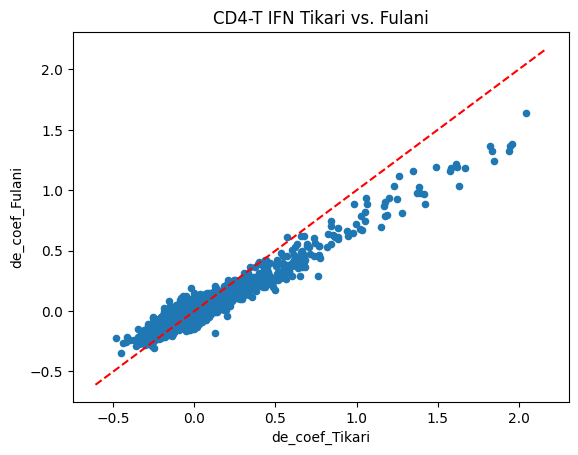

In [124]:
results_tf.plot.scatter(x = 'de_coef_Tikari', y='de_coef_Fulani')
plt.title("{} {} Tikari vs. Fulani".format(ctype,cond))
xlims = plt.xlim()
ylims = plt.ylim()
min_limit = min(xlims[0], ylims[0])
max_limit = max(xlims[1], ylims[1])
plt.plot([min_limit, max_limit], [min_limit, max_limit], color='red', linestyle='--', label='Equivalence Line')

In [28]:
ctype="CD4-T"
cond="LPS"

results_t = pd.read_csv("output/memento.{}.Tikari.CTL_{}.COND.csv".format(ctype,cond), index_col=0)
results_f = pd.read_csv("output/memento.{}.Fulani.CTL_{}.COND.csv".format(ctype,cond), index_col=0)
results_c = pd.read_csv("output/memento.{}.CHG.CTL_{}.COND.csv".format(ctype,cond), index_col=0)

results_tf = results_t[['gene','de_coef']].rename(columns={'de_coef': 'de_coef_Tikari'}) \
    .merge(results_f[['gene','de_coef']].rename(columns={'de_coef': 'de_coef_Fulani'}))
results_tc = results_t[['gene','de_coef']].rename(columns={'de_coef': 'de_coef_Tikari'}) \
    .merge(results_c[['gene','de_coef']].rename(columns={'de_coef': 'de_coef_CHG'}))
results_fc = results_f[['gene','de_coef']].rename(columns={'de_coef': 'de_coef_Fulani'}) \
    .merge(results_c[['gene','de_coef']].rename(columns={'de_coef': 'de_coef_CHG'}))


In [33]:
results_c.sort_values('de_coef').tail(20)

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
4403,OAS2,LPS,0.938061,0.010680,0.0,0.157775,0.044748,1.385694e-02
1457,PARP9,LPS,0.969661,0.008739,0.0,-0.120346,0.030684,4.412012e-05
3724,IRF7,LPS,0.988380,0.013726,0.0,0.264088,0.059020,5.833758e-04
1875,DDX60,LPS,1.006846,0.010161,0.0,-0.091130,0.035246,5.021688e-03
3171,LY6E,LPS,1.019288,0.008135,0.0,0.418516,0.040211,5.227897e-21
1075,STAT1,LPS,1.027474,0.006593,0.0,-0.175474,0.027135,5.010945e-11
758,EIF2AK2,LPS,1.047519,0.008168,0.0,0.052640,0.026052,1.485964e-01
1773,HERC6,LPS,1.054361,0.011319,0.0,-0.014908,0.038702,4.352004e-01
4529,EPSTI1,LPS,1.062603,0.007199,0.0,-0.046226,0.024787,3.324069e-02
2780,SAMD9L,LPS,1.081077,0.009542,0.0,0.273892,0.032363,1.447526e-13


In [113]:
results_fc[(results_fc['de_coef_Fulani'] > 1) & (results_fc['de_coef_CHG'] < 1)]

,gene,de_coef_Fulani,de_coef_CHG
234,GBP1,1.116623,0.99926
5436,APOL6,1.035473,0.99670


In [ ]:
results_fc[(results_fc['de_coef_Fulani'] > 0.5) & (results_fc['de_coef_CHG'] < 0.5)]

##### Explore

In [3]:
results_t = pd.read_csv("output/memento.M.Tikari.CTL_LPS.COND.csv", index_col=0)

In [4]:
results_c = pd.read_csv("output/memento.M.CHG.CTL_LPS.COND.csv", index_col=0)

In [5]:
results_f = pd.read_csv("output/memento.M.Fulani.CTL_LPS.COND.csv", index_col=0)

In [6]:
results_t['nlt_pval'] = -np.log10(results_t['de_pval'])
results_c['nlt_pval'] = -np.log10(results_c['de_pval'])
results_f['nlt_pval'] = -np.log10(results_f['de_pval'])

/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [39]:
np.sum(multipletests(results_f['de_pval'], method='fdr_bh', alpha=0.01)[1] < 0.01)

5577

In [40]:
results_f['qval'] = multipletests(results_f['de_pval'], method='fdr_bh', alpha=0.01)[1]

<Axes: xlabel='de_coef', ylabel='nlt_pval'>

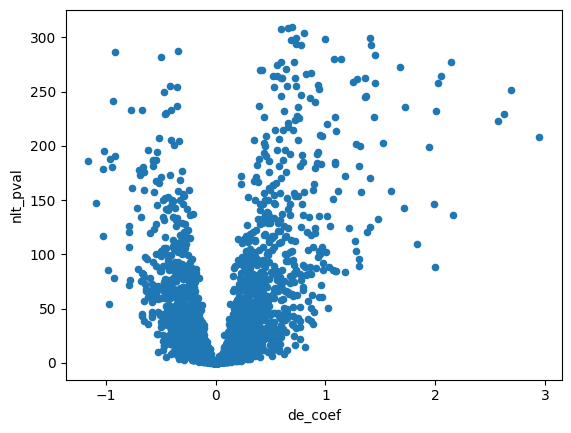

In [9]:
results_f.plot.scatter(x = 'de_coef', y = 'nlt_pval')

In [14]:
results_f.sort_values('de_coef', ascending=False).head()

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,nlt_pval
2431,IDO1,LPS,2.948697,0.090612,1.944367e-208,0.669247,0.249556,7.177119e-01,207.711222
804,TNFAIP6,LPS,2.925939,0.062089,0.000000e+00,0.669171,0.170248,6.479892e-02,inf
2478,AC083837.1,LPS,2.694465,0.060650,0.000000e+00,0.366343,0.115764,7.527952e-02,inf
2130,ITGB8,LPS,2.689160,0.075387,6.390269e-252,-0.719282,0.129785,1.497295e-08,251.194481
1380,CXCL1,LPS,2.626744,0.078612,1.251581e-229,0.288273,0.138399,8.938075e-01,228.902541


<Axes: xlabel='de_coef', ylabel='nlt_pval'>

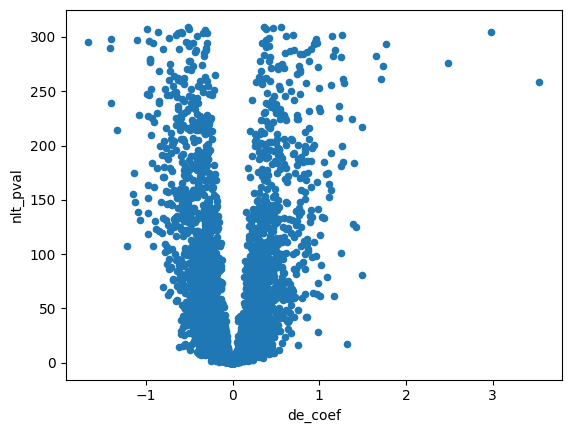

In [13]:
results_t.plot.scatter(x = 'de_coef', y = 'nlt_pval')

<Axes: xlabel='de_coef', ylabel='nlt_pval'>

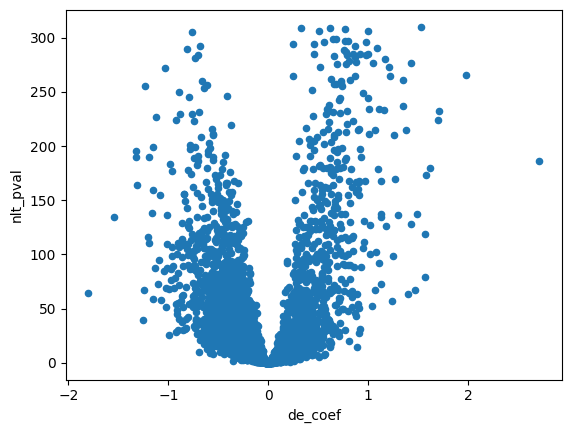

In [29]:
results_c.plot.scatter(x = 'de_coef', y = 'nlt_pval')

<Axes: xlabel='de_coef', ylabel='nlt_pval'>

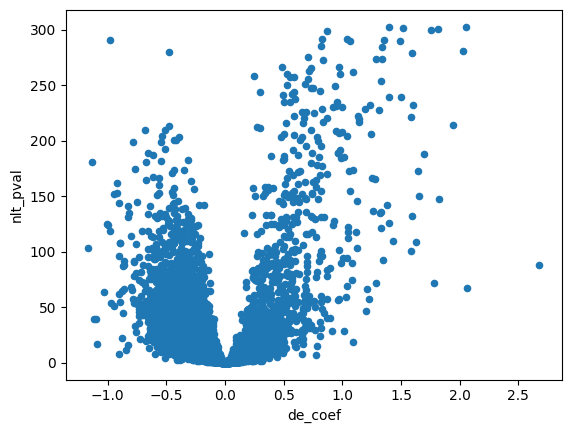

In [30]:
results_f.plot.scatter(x = 'de_coef', y = 'nlt_pval')

In [33]:
# if you are only intrested in dataframe that enrichr returned, please set outdir=None
# weight for factor 30, from most to least significant
gene_list = list(results_f[(results_f['qval'] < 0.01) & (results_f['de_coef'] < 0.5)]['gene'])
enr = gp.enrichr(gene_list=gene_list, # or "./tests/data/gene_list.txt",
                 gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human'],
                 background=list(results_f['gene']),
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

In [34]:
enr.results.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Oxidative Phosphorylation,160/200,2.481749e-54,1.240874e-52,0,0,10.845361,1338.649736,MTRR;ACAA2;ECI1;COX6A1;PHB2;MPC1;ATP6V1E1;PDHX...
1,MSigDB_Hallmark_2020,Myc Targets V1,155/200,2.476797e-49,6.191993e-48,0,0,9.327091,1043.885272,EIF4A1;HDDC2;RPL34;HNRNPU;PWP1;PHB2;RPL6;PSMD8...
2,MSigDB_Hallmark_2020,mTORC1 Signaling,124/200,1.317523e-24,2.195872e-23,0,0,4.383179,241.014727,ERO1A;TFRC;PITPNB;UBE2D3;ARPC5L;SLA;ENO1;IFI30...
3,MSigDB_Hallmark_2020,Adipogenesis,113/200,4.452264e-18,5.565330e-17,0,0,3.479529,139.018055,MTCH2;ACAA2;GHITM;COX6A1;SCP2;PIM3;APLP2;MCCC1...
4,MSigDB_Hallmark_2020,Unfolded Protein Response,72/113,8.552975e-16,8.552975e-15,0,0,4.683790,162.504492,EIF4A2;ERO1A;EIF4A1;POP4;EIF4A3;HERPUD1;RPS14;...


In [35]:
results_f[results_f['de_coef'] < 0].sort_values('de_pval').head()

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,nlt_pval,qval
5330,ABHD2,IFN,-0.935742,0.023899,0.000000e+00,0.047488,0.067540,3.722881e-01,inf,0.000000e+00
3778,ADK,IFN,-0.822144,0.019712,0.000000e+00,0.264165,0.050338,9.390442e-08,inf,0.000000e+00
3036,TBXAS1,IFN,-0.977124,0.026658,2.121961e-291,0.027369,0.070402,5.110033e-01,290.673263,7.469509e-290
6668,CEBPB,IFN,-0.478570,0.013355,1.759114e-280,0.519650,0.035122,3.457297e-49,279.754706,5.986822e-279
4028,CD44,IFN,-0.479839,0.015376,1.276643e-213,0.429066,0.039471,1.006705e-27,212.893930,3.433549e-212


In [42]:
results_f[~results_f['gene'].isin(results_t['gene'])].sort_values('de_coef', ascending=False).head(10)

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,nlt_pval
0,ISG15,IFN,3.317789,0.041832,0.000000e+00,0.605830,0.192827,0.003849,inf
1439,MX1,IFN,3.249476,0.061306,0.000000e+00,0.186920,0.193092,0.491378,inf
414,HERC5,IFN,2.884851,0.056421,0.000000e+00,0.002858,0.170740,0.752922,inf
1438,MX2,IFN,2.782273,0.053383,0.000000e+00,0.330715,0.232064,0.130612,inf
1229,ISG20,IFN,2.612733,0.035464,0.000000e+00,0.336115,0.190916,0.046324,inf
449,DDX60L,IFN,2.353435,0.050488,0.000000e+00,0.390520,0.193283,0.022551,inf
154,EIF2AK2,IFN,2.231467,0.042840,0.000000e+00,-0.511443,0.167537,0.003559,inf
54,GBP1,IFN,2.095319,0.063941,2.793455e-223,0.536062,0.207207,0.013406,222.553858
682,SAMD9,IFN,1.983043,0.037614,0.000000e+00,0.161547,0.183577,0.412264,inf
1063,OASL,IFN,1.860341,0.056623,1.037378e-223,-0.183968,0.236798,0.574324,222.984063


In [37]:
results_c[results_c['gene']=="MX2"]

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,nlt_pval


In [35]:
results_c[~results_c['gene'].isin(results_f['gene'])].sort_values('de_coef', ascending=False).head(10)

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,nlt_pval
257,PARP9,IFN,1.827717,0.042441,0.000000e+00,-0.123242,0.170481,0.550163,inf
621,DDX58,IFN,1.797977,0.036607,0.000000e+00,0.397657,0.139767,0.012427,inf
277,TNFSF10,IFN,1.555623,0.043548,2.054096e-265,0.943606,0.172719,0.000002,264.687379
176,GPR155,IFN,1.253079,0.050282,1.289865e-126,0.386326,0.131424,0.026347,125.889456
760,HSPA8,IFN,0.964223,0.027663,2.002148e-259,0.461443,0.187393,0.007065,258.698504
905,SPTLC2,IFN,0.785928,0.051667,1.532430e-48,0.134187,0.158305,0.318429,47.814619
560,PRKAG2,IFN,0.609034,0.046293,2.623275e-38,0.017804,0.157158,0.748726,37.581156
807,PCED1B-AS1,IFN,0.561040,0.028283,1.827200e-86,0.351115,0.165430,0.026064,85.738214
527,CCDC146,IFN,0.521827,0.057286,1.707512e-18,0.191156,0.141252,0.232575,17.767636
602,PVT1,IFN,0.414324,0.086329,4.271865e-06,0.197091,0.174331,0.293654,5.369382


In [44]:
results_cf = results_c[['gene','de_coef']].rename(columns={'de_coef': 'de_coef_CHG'}) \
    .merge(results_f[['gene','de_coef']].rename(columns={'de_coef': 'de_coef_Fulani'}))

<Axes: xlabel='de_coef_Fulani', ylabel='de_coef_CHG'>

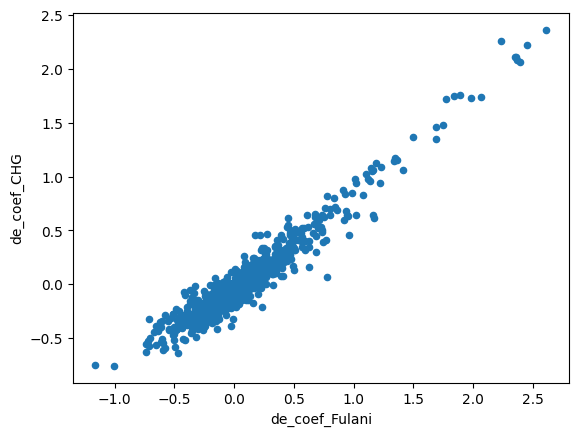

In [45]:
results_cf.plot.scatter(x = 'de_coef_Fulani', y='de_coef_CHG')

In [36]:
# plotting response to LPS vs IFN
results_fi = pd.read_csv("output/memento.M.Fulani.CTL_IFN.COND.csv", index_col=0)
results_fl = pd.read_csv("output/memento.M.Fulani.CTL_LPS.COND.csv", index_col=0)

In [40]:
results_fl.sort_values('de_coef').tail()

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
964,IL1B,LPS,3.148832,0.070015,0.000000e+00,-3.205559,0.080976,0.000000e+00
3105,AC083837.1,LPS,3.545162,0.090409,0.000000e+00,0.272489,0.162706,3.404408e-01
2677,ITGB8,LPS,3.574412,0.112088,1.989429e-203,-1.127028,0.172699,3.385247e-11
1743,CXCL1,LPS,3.579022,0.120706,2.580242e-179,0.292136,0.198206,9.853704e-01
5533,CCL1,LPS,4.450235,0.103262,0.000000e+00,-1.861906,0.185342,4.810423e-24


In [ ]:
# if you are only intrested in dataframe that enrichr returned, please set outdir=None
# weight for factor 30, from most to least significant
gene_list = list(results_f[(results_f['qval'] < 0.01) & (results_f['de_coef'] < 0.5)]['gene'])
enr = gp.enrichr(gene_list=gene_list, # or "./tests/data/gene_list.txt",
                 gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human'],
                 background=list(results_f['gene']),
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

In [37]:
results_fil = results_fi[['gene','de_coef']].rename(columns={'de_coef': 'de_coef_IFN'}) \
    .merge(results_fl[['gene','de_coef']].rename(columns={'de_coef': 'de_coef_LPS'}))

<Axes: xlabel='de_coef_IFN', ylabel='de_coef_LPS'>

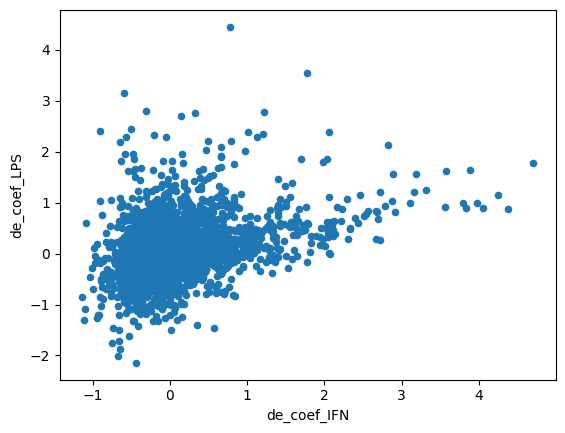

In [38]:
results_fil.plot.scatter(x = 'de_coef_IFN', y='de_coef_LPS')

In [18]:
results_f.sort_values('de_coef').head()

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,nlt_pval
6225,PRAM1,IFN,-1.166056,0.052915,2.116429e-104,-0.266477,0.150868,0.108147,103.674396
5477,KIF22,IFN,-1.133115,0.039037,1.556329e-181,-0.429082,0.140484,0.011897,180.807899
1338,STAC,IFN,-1.117239,0.082788,1.811753e-40,-0.601594,0.123878,0.000015,39.741901
2809,EEPD1,IFN,-1.097203,0.079170,1.726460e-40,0.158812,0.154237,0.159661,39.762844
1217,PID1,IFN,-1.093707,0.119257,6.352725e-18,0.209752,0.197455,0.146155,17.197040


In [19]:
results_cf[(results_cf['de_coef_CHG'] > 0.5) & (results_cf['de_coef_Fulani'] < 0.1)]

,gene,de_coef_CHG,de_coef_Fulani


In [20]:
results_cf[(results_cf['de_coef_Fulani'] > 0.5) & (np.abs(results_cf['de_coef_CHG']) < 0.2)]

,gene,de_coef_CHG,de_coef_Fulani


In [21]:
sig_c = results_c[multipletests(results_c['de_pval'], method='fdr_bh', alpha=0.01)[0]]

In [22]:
sig_f = results_f[multipletests(results_f['de_pval'], method='fdr_bh', alpha=0.01)[0]]

In [23]:
uniq_f = set(sig_f[sig_f['gene'].isin(results_c['gene'])]['gene']).difference(set(sig_c[sig_c['gene'].isin(results_f['gene'])]['gene']))
uniq_c = set(sig_c[sig_c['gene'].isin(results_f['gene'])]['gene']).difference(set(sig_f[sig_f['gene'].isin(results_c['gene'])]['gene']))

In [27]:
sig_f[sig_f['gene'].isin(uniq_f)].sort_values('de_coef').tail()

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,nlt_pval
5704,AC002091.1,IFN,0.197699,0.050459,1.255741e-04,0.420790,0.216473,0.036507,3.901100
4765,N4BP2L1,IFN,0.207355,0.036082,2.195139e-08,0.074183,0.135570,0.910342,7.658538
112,PTAFR,IFN,0.209062,0.029945,3.784431e-12,-0.084616,0.048715,0.077247,11.421999
1671,MB21D2,IFN,0.270370,0.040089,3.899797e-11,-0.316420,0.076571,0.000018,10.408958
6039,L3MBTL4,IFN,0.287436,0.065915,3.726709e-05,0.008148,0.195374,0.897189,4.428675


In [26]:
sig_c[sig_c['gene'].isin(uniq_c)].sort_values('de_coef').head()

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,nlt_pval
101,MARCKSL1,IFN,-0.586068,0.092586,2.101039e-09,0.202310,0.242415,0.230448,8.677566
5147,ENTHD1,IFN,-0.575003,0.084145,2.923526e-11,-0.344031,0.122296,0.022629,10.534093
4365,KSR1,IFN,-0.508290,0.055888,1.166057e-19,-0.314727,0.148521,0.041777,18.933280
2727,TRAF1,IFN,-0.472261,0.046361,1.633963e-22,0.405170,0.120136,0.000388,21.786758
1739,SPINK1,IFN,-0.440537,0.073390,4.720887e-09,0.024382,0.079665,0.460558,8.325976


In [90]:
results_c[results_c['gene'].isin(uniq_f)].sort_values('de_coef').head()

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,nlt_pval
1489,AC092353.2,LPS,-0.239686,0.091996,0.008537,-0.282078,0.108718,0.005912,2.068719
1626,JAKMIP2-AS1,LPS,-0.217671,0.082952,0.014546,0.081993,0.181605,0.392465,1.837251
546,DTNB,LPS,-0.154951,0.074087,0.057524,0.062300,0.111193,0.461687,1.240148
1839,TENT5A,LPS,-0.147564,0.051368,0.010532,-0.075802,0.121931,0.815094,1.977490
2829,INPP5A,LPS,-0.146290,0.052508,0.010339,0.297123,0.125887,0.018083,1.985515


In [91]:
results_f[results_f['gene'].isin(uniq_c)].sort_values('de_coef').tail()

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,nlt_pval
4789,SGPP1,LPS,0.123765,0.055323,0.022381,0.102456,0.161379,0.444444,1.650125
4864,AL135818.1,LPS,0.126109,0.052041,0.012378,-0.111147,0.129798,0.574994,1.907360
1937,RAI14,LPS,0.144876,0.074508,0.044417,-0.148293,0.097538,0.192704,1.352452
177,SCMH1,LPS,0.168953,0.067093,0.010467,-0.050247,0.122041,0.748740,1.980196
6401,MAP3K7CL,LPS,0.179617,0.083031,0.022436,0.621786,0.207549,0.001575,1.649064


#### Between populations

In [7]:
popde_dfs = []

ctypes = ["B","CD4-T","CD8-T","NK","M","gdT","MAIT"]
pops=["Tikari_Fulani","Tikari_CHG","Fulani_CHG"]
conds=["CTL","IFN","LPS"]
for ctype in ctypes:

    for pop in pops:
    
        for cond in conds:
        
            results = pd.read_csv("output/memento.{}.{}.{}.Ethnicity.csv".format(ctype,pop,cond), index_col=0)
            # results = pd.read_csv("output/memento.M.Tikari_Fulani.CTL.Ethnicity.csv", index_col=0)
    
            # remove mitochondrial and ribosomal genes
            results = results[~results['gene'].str.startswith(("MT","RPL","RPS","MALAT1"))]
    
            results['ctype'] = ctype
    
            results['pop'] = pop
    
            results['cond'] = cond
    
            results['qval'] = multipletests(results['de_pval'], method='fdr_bh', alpha=0.05)[1]
    
            popde_dfs.append(results)

In [8]:
popde_df = pd.concat(popde_dfs)

In [13]:
popde_df[(popde_df['pop']=="Tikari_Fulani") & \
    (popde_df['ctype']=="M") & \
    (popde_df['cond']=="CTL")].sort_values('de_pval').head(20)

,gene,tx,de_coef,de_se,de_pval,ctype,pop,cond,qval
0,ITGB2,Fulani,0.000405,6.048393e-05,1.298016e-11,M,Tikari_Fulani,CTL,2.040481e-07
0,LRRC28,Fulani,0.000018,2.923883e-06,3.216944e-10,M,Tikari_Fulani,CTL,2.528518e-06
0,CTSA,Fulani,-0.000017,2.909842e-06,3.790199e-09,M,Tikari_Fulani,CTL,1.986064e-05
0,SUMF1,Fulani,0.000037,6.745817e-06,4.928481e-08,M,Tikari_Fulani,CTL,1.936893e-04
0,GTF2I,Fulani,0.000040,7.661316e-06,2.955846e-07,M,Tikari_Fulani,CTL,9.293180e-04
0,DNAJC15,Fulani,-0.000030,6.039006e-06,8.037531e-07,M,Tikari_Fulani,CTL,2.105833e-03
0,ATP8B4,Fulani,-0.000131,2.682288e-05,9.780538e-07,M,Tikari_Fulani,CTL,2.196429e-03
0,CTSD,Fulani,-0.000151,3.166138e-05,1.345330e-06,M,Tikari_Fulani,CTL,2.643573e-03
0,AC015660.2,Fulani,0.000038,7.976687e-06,1.827021e-06,M,Tikari_Fulani,CTL,3.191197e-03
0,MPP1,Fulani,-0.000015,3.274727e-06,2.498182e-06,M,Tikari_Fulani,CTL,3.927143e-03


In [19]:
ctype="M"
pop="Tikari_Fulani"
cond="CTL"

r1 = pd.read_csv("output/memento.{}.{}.{}.Ethnicity.csv".format(ctype, pop, cond), index_col=0)
r1 = r1[~r1['gene'].str.startswith(("MT","RPL","RPS","MALAT1"))]
r1['ctype'] = ctype
r1['pop'] = pop
r1['cond'] = cond
r1['qval'] = multipletests(r1['de_pval'], method='fdr_bh', alpha=0.05)[1]

In [21]:
r1['nltpval'] = -np.log10(r1['de_pval'])

In [23]:
r1.head()

,gene,tx,de_coef,de_se,de_pval,ctype,pop,cond,qval,nltpval
0,A1BG,Fulani,3.053886e-06,1.168040e-06,0.008875,M,Tikari_Fulani,CTL,0.066298,2.051826
0,A1BG-AS1,Fulani,1.250095e-06,4.803403e-07,0.008612,M,Tikari_Fulani,CTL,0.065154,2.064892
0,A2M,Fulani,-1.753031e-05,1.645868e-05,0.281518,M,Tikari_Fulani,CTL,0.525631,0.550494
0,A2M-AS1,Fulani,8.744094e-08,1.861645e-07,0.618932,M,Tikari_Fulani,CTL,0.802236,0.208357
0,A2ML1,Fulani,-2.491994e-06,9.921187e-07,0.014854,M,Tikari_Fulani,CTL,0.090471,1.828148


<Axes: xlabel='de_coef', ylabel='nltpval'>

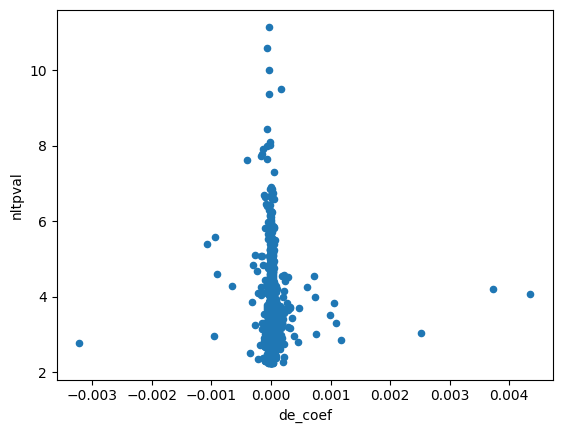

In [27]:
r1[r1['qval']<0.05].plot.scatter(x='de_coef', y='nltpval')

In [29]:
r1.sort_values('de_coef', ascending=False).head()

,gene,tx,de_coef,de_se,de_pval,ctype,pop,cond,qval,nltpval
0,CXCL8,Fulani,0.004353,0.001082,0.000085,M,Tikari_Fulani,CTL,0.004960,4.073062
0,IL1B,Fulani,0.003734,0.000916,0.000061,M,Tikari_Fulani,CTL,0.004223,4.213828
0,CXCL5,Fulani,0.002526,0.000760,0.000930,M,Tikari_Fulani,CTL,0.018032,3.031322
0,FTH1,Fulani,0.001833,0.001370,0.191154,M,Tikari_Fulani,CTL,0.421772,0.718616
0,SERPINB2,Fulani,0.001177,0.000362,0.001414,M,Tikari_Fulani,CTL,0.022588,2.849466


In [17]:
ctype="M"
pop="Fulani_Other"
cond="CTL"

r2 = pd.read_csv("output/memento.{}.{}.{}.Ethnicity.csv".format(ctype, pop, cond), index_col=0)
r2 = r2[~r2['gene'].str.startswith(("MT","RPL","RPS","MALAT1"))]
r2['ctype'] = ctype
r2['pop'] = pop
r2['cond'] = cond
r2['qval'] = multipletests(r2['de_pval'], method='fdr_bh', alpha=0.05)[1]

FileNotFoundError: [Errno 2] No such file or directory: 'output/memento.M.Fulani_Other.CTL.Ethnicity.csv'

In [18]:
r1[['gene','de_coef']].merge(r2[['gene','de_coef']], left_on="gene", right_on="gene").plot.scatter(x="de_coef_x", y="de_coef_y")

NameError: name 'r2' is not defined

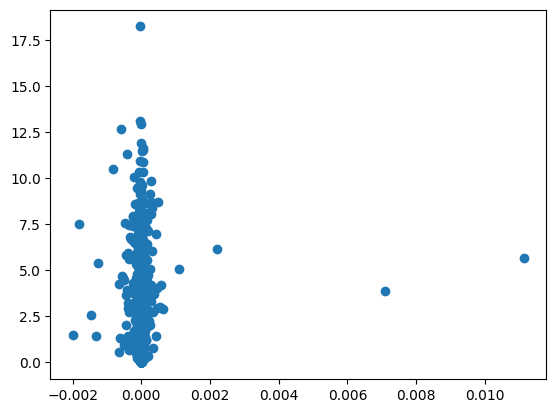

In [31]:
plt.scatter(x = r1['de_coef'], y = -np.log10(r1['de_pval']))

In [34]:
r1.sort_values('de_pval', ascending=True)

,gene,tx,de_coef,de_se,de_pval,ctype,pop,cond,qval
0,OTUD7B,CHG,-3.694049e-05,4.159778e-06,5.816998e-19,M,Fulani_CHG,CTL,9.035543e-15
0,HBEGF,CHG,-4.675008e-05,6.254840e-06,8.109225e-14,M,Fulani_CHG,CTL,6.021067e-10
0,C19orf71,CHG,-9.614719e-06,1.302789e-06,1.162892e-13,M,Fulani_CHG,CTL,6.021067e-10
0,INHBA,CHG,-5.973473e-04,8.141583e-05,2.247624e-13,M,Fulani_CHG,CTL,8.728086e-10
0,TLE3,CHG,-1.819251e-05,2.580386e-06,1.253630e-12,M,Fulani_CHG,CTL,3.894528e-09
...,...,...,...,...,...,...,...,...,...
0,MIR4458HG,CHG,6.121427e-08,7.977959e-07,9.994894e-01,M,Fulani_CHG,CTL,9.997468e-01
0,CARS-AS1,CHG,9.762364e-10,2.321704e-07,9.995937e-01,M,Fulani_CHG,CTL,9.997868e-01
0,AC020594.1,CHG,-1.828092e-08,4.579231e-07,9.996820e-01,M,Fulani_CHG,CTL,9.997952e-01
0,AL034417.4,CHG,-1.859337e-08,2.707586e-07,9.997581e-01,M,Fulani_CHG,CTL,9.997952e-01


In [4]:
popde_df = pd.concat(popde_dfs)

In [5]:
popde_sig = popde_df[popde_df['qval'] < 0.05]

In [6]:
popde_sig.groupby(['ctype','pop','cond']).size()

ctype  pop     cond
B      CHG     CTL     2090
               IFN     2900
               LPS     1793
       Fulani  CTL      505
               IFN     1154
               LPS     1433
       Tikari  CTL      105
               IFN      235
               LPS      780
CD4-T  CHG     CTL     1728
               IFN     2180
               LPS      884
       Fulani  CTL      835
               IFN     1720
               LPS     2517
       Tikari  CTL     1296
               IFN      822
               LPS     2542
M      CHG     CTL     1590
               IFN     3077
               LPS      560
       Fulani  CTL      293
               IFN     1014
               LPS      209
       Tikari  CTL       31
               IFN       45
               LPS       42
MAIT   CHG     CTL        3
               IFN        2
       Fulani  CTL        4
               IFN        2
               LPS        4
       Tikari  CTL        4
               IFN        1
               LPS        4


In [7]:
ctype="M"
cond="CTL"
pop="Fulani"

In [8]:
popde_sig[popde_sig['pop']=="Tikari"].sort_values('de_coef', ascending=False).head(15)

,gene,tx,de_coef,de_se,de_pval,ctype,pop,cond,qval
0,CCL4L2,Tikari,0.001431,0.000356,7.464218e-05,M,Tikari,LPS,0.034465
0,GNLY,Tikari,0.001123,0.000303,2.435714e-04,NK,Tikari,IFN,0.042857
0,GNLY,Tikari,0.000842,0.000255,1.054094e-03,NK,Tikari,LPS,0.044453
0,C15orf48,Tikari,0.000802,0.000153,1.139935e-07,M,Tikari,LPS,0.000597
0,CTSL,Tikari,0.000797,0.000154,3.093164e-07,M,Tikari,IFN,0.001584
0,ISG15,Tikari,0.000759,0.000200,1.588771e-04,NK,Tikari,LPS,0.020075
0,B2M,Tikari,0.000629,0.000178,5.607248e-04,CD4-T,Tikari,LPS,0.006799
0,CCL4L2,Tikari,0.000621,0.000147,2.550048e-05,M,Tikari,IFN,0.016978
0,TMSB4X,Tikari,0.000603,0.000179,8.701634e-04,NK,Tikari,LPS,0.041242
0,ISG15,Tikari,0.000510,0.000109,2.238030e-06,gdT,Tikari,LPS,0.004037


In [23]:
adata = sc.read_h5ad("../../test/test123/write/qc_020725.spectra_out.4k.h5ad")

/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:771: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed

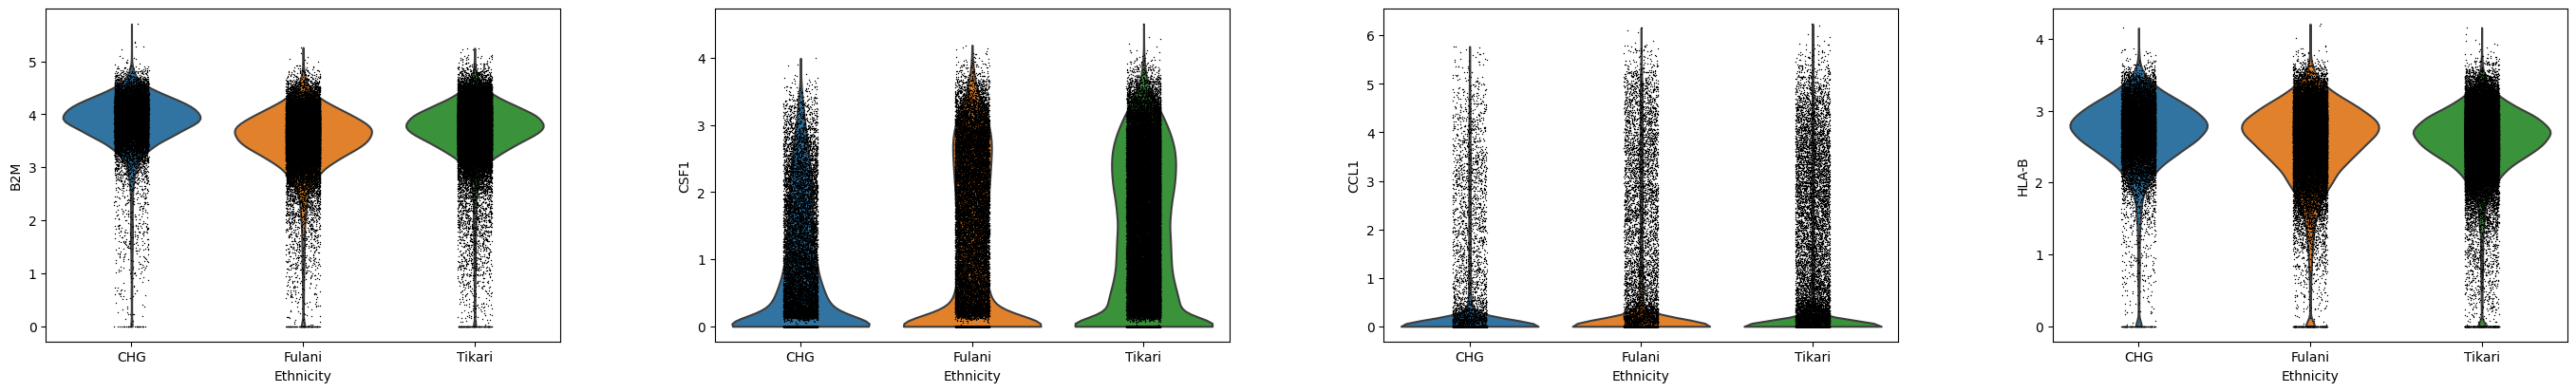

In [36]:
sc.pl.violin(adata[adata.obs['cytopus_names']=="M"], keys=['B2M','CSF1','CCL1','HLA-B'], groupby="Ethnicity")

In [13]:
popde_tmp = popde_sig[(popde_sig['ctype']==ctype) & \
    (popde_sig['cond']==cond) & \
    (popde_sig['pop']==pop)]

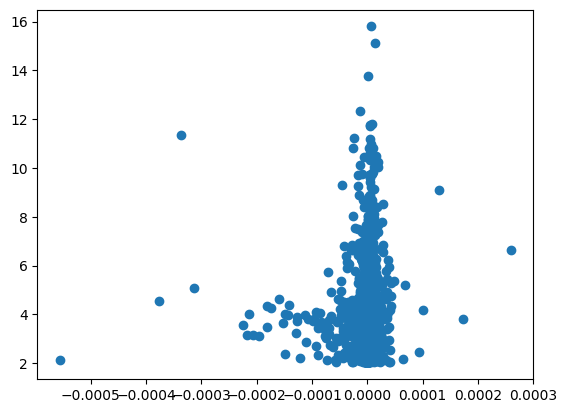

In [14]:
plt.scatter(x = popde_tmp['de_coef'], y = -np.log10(popde_tmp['de_pval']))

In [18]:
popde_tmp.sort_values('de_coef').tail()

,gene,tx,de_coef,de_se,de_pval,ctype,pop,cond,qval
0,CCL5,Fulani,0.000093,0.000032,3.397260e-03,CD4-T,Fulani,LPS,2.416753e-02
0,SNHG5,Fulani,0.000101,0.000025,6.675499e-05,CD4-T,Fulani,LPS,1.518335e-03
0,LTB,Fulani,0.000130,0.000021,7.733217e-10,CD4-T,Fulani,LPS,2.721685e-07
0,PABPC1,Fulani,0.000173,0.000046,1.616924e-04,CD4-T,Fulani,LPS,2.765313e-03
0,IL7R,Fulani,0.000260,0.000051,2.246253e-07,CD4-T,Fulani,LPS,2.365464e-05


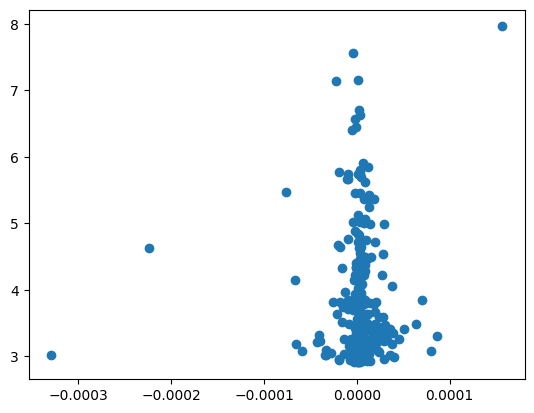

In [144]:
plt.scatter(x = popde_tc['de_coef'], y = -np.log10(popde_tc['de_pval']))

In [149]:
popde_tc.sort_values('de_coef').tail()

,gene,tx,de_coef,de_se,de_pval,ctype,cond,pops,qval
0,RUNX1,CHG,0.000064,0.000018,3.261713e-04,CD4-T,LPS,Tikari_CHG,0.028588
0,SKAP1,CHG,0.000070,0.000018,1.402928e-04,CD4-T,LPS,Tikari_CHG,0.019789
0,LDLRAD4,CHG,0.000080,0.000024,8.258410e-04,CD4-T,LPS,Tikari_CHG,0.042262
0,EPB41,CHG,0.000087,0.000025,4.889141e-04,CD4-T,LPS,Tikari_CHG,0.033622
0,THEMIS,CHG,0.000156,0.000027,1.095346e-08,CD4-T,LPS,Tikari_CHG,0.000147


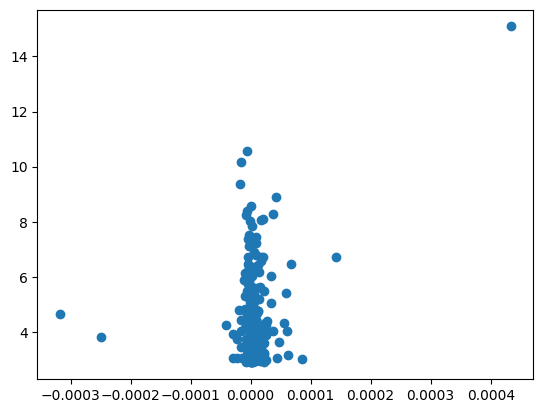

In [146]:
plt.scatter(x = popde_fc['de_coef'], y = -np.log10(popde_fc['de_pval']))

In [152]:
popde_fc.sort_values('de_coef').head(15)

,gene,tx,de_coef,de_se,de_pval,ctype,cond,pops,qval
0,PABPC1,CHG,-0.000318,0.000076,2.340044e-05,CD4-T,LPS,Fulani_CHG,3.922499e-03
0,IL7R,CHG,-0.000249,0.000067,1.475258e-04,CD4-T,LPS,Fulani_CHG,1.301527e-02
0,SMDT1,CHG,-0.000041,0.000010,5.827314e-05,CD4-T,LPS,Fulani_CHG,6.736576e-03
0,JUNB,CHG,-0.000030,0.000008,1.158599e-04,CD4-T,LPS,Fulani_CHG,1.064166e-02
0,CD7,CHG,-0.000029,0.000009,8.948361e-04,CD4-T,LPS,Fulani_CHG,4.095478e-02
0,AL589693.1,CHG,-0.000023,0.000006,1.747051e-04,CD4-T,LPS,Fulani_CHG,1.482782e-02
0,LINC01876,CHG,-0.000022,0.000007,8.532263e-04,CD4-T,LPS,Fulani_CHG,3.945436e-02
0,SERPINB1,CHG,-0.000019,0.000004,1.655458e-05,CD4-T,LPS,Fulani_CHG,3.180605e-03
0,RTKN2,CHG,-0.000018,0.000003,4.300933e-10,CD4-T,LPS,Fulani_CHG,1.441888e-06
0,LINC01871,CHG,-0.000017,0.000004,9.269642e-05,CD4-T,LPS,Fulani_CHG,9.140140e-03


In [87]:
popde_tmp = popde_sig[(popde_sig['ctype']==ctype) & \
    (popde_sig['cond']==cond) & \
    (popde_sig['pops']==pops)]

In [88]:
popde_tmp['nlt_pval'] = -np.log10(popde_tmp['de_pval'])

/tmp/ipykernel_206632/3115281804.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popde_tmp['nlt_pval'] = -np.log10(popde_tmp['de_pval'])


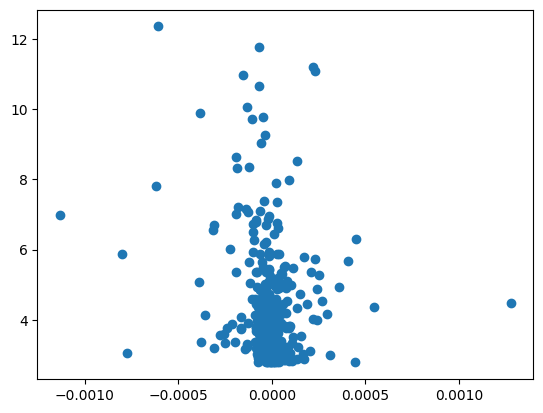

In [89]:
plt.scatter(x = popde_tmp['de_coef'], y = popde_tmp['nlt_pval'])

In [134]:
ctype="M"
cond="LPS"
pops="Tikari_CHG"

In [135]:
# if you are only intrested in dataframe that enrichr returned, please set outdir=None
# weight for factor 30, from most to least significant
gene_list = list(popde_sig[(popde_sig['ctype']==ctype) & \
    (popde_sig['cond']==cond) & \
    (popde_sig['pops']==pops) & \
    (popde_sig['de_coef'] > 0)]['gene'])

bground = list(popde_df[(popde_df['ctype']==ctype) & \
    (popde_df['cond']==cond) & \
    (popde_df['pops']==pops)]['gene'])

enr = gp.enrichr(gene_list=gene_list, # or "./tests/data/gene_list.txt",
#                 gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human','GO_Biological_Process_2025','Reactome_Pathways_2024'],
                 gene_sets=['GO_Biological_Process_2025'],
                 background=bground,
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

In [136]:
enr.results[enr.results['Gene_set']=="GO_Biological_Process_2025"].sort_values('P-value').head(20)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2025,Lysosomal Lumen Acidification (GO:0007042),3/20,0.000072,0.036883,0,0,44.454952,424.045068,ATP6V1A;LAMP1;ATP6V1H
1,GO_Biological_Process_2025,Positive Regulation of Toll-Like Receptor 2 Si...,2/5,0.000165,0.036883,0,0,165.958333,1445.699084,MFHAS1;PJA2
2,GO_Biological_Process_2025,Regulation of Lysosomal Lumen pH (GO:0035751),3/27,0.000181,0.036883,0,0,31.477848,271.250594,ATP6V1A;LAMP1;ATP6V1H
3,GO_Biological_Process_2025,Vacuolar Acidification (GO:0007035),3/31,0.000275,0.036883,0,0,26.975588,221.181914,ATP6V1A;LAMP1;ATP6V1H
4,GO_Biological_Process_2025,Intracellular pH Reduction (GO:0051452),3/31,0.000275,0.036883,0,0,26.975588,221.181914,ATP6V1A;ATP6V1H;TPCN2
5,GO_Biological_Process_2025,Golgi Lumen Acidification (GO:0061795),2/9,0.000587,0.065616,0,0,71.110714,529.130660,ATP6V1A;ATP6V1H
6,GO_Biological_Process_2025,Regulation of Toll-Like Receptor 2 Signaling P...,2/10,0.000731,0.070116,0,0,62.218750,449.248076,MFHAS1;PJA2
7,GO_Biological_Process_2025,Endosomal Lumen Acidification (GO:0048388),2/11,0.000892,0.074786,0,0,55.302778,388.361181,ATP6V1A;ATP6V1H
8,GO_Biological_Process_2025,Proton Transmembrane Transport (GO:1902600),3/51,0.001200,0.081835,0,0,15.719937,105.718538,ATP6V1A;ATP6V1H;ATP6V1C1
9,GO_Biological_Process_2025,Negative Regulation of Toll-Like Receptor 4 Si...,2/13,0.001258,0.081835,0,0,45.243182,302.152132,MFHAS1;TAX1BP1


In [48]:
results_f = pd.read_csv("output/memento.CD8-T.Fulani_Other.CTL.Ethnicity.csv", index_col=0)
results_f.head()

,gene,tx,de_coef,de_se,de_pval
0,A1BG,Fulani,6.742013e-06,2.663706e-06,0.012181
0,A1BG-AS1,Fulani,7.816076e-07,5.867986e-07,0.170855
0,A2M,Fulani,8.759819e-06,1.489256e-05,0.568369
0,A2M-AS1,Fulani,1.918492e-06,2.627764e-06,0.484806
0,A2ML1-AS1,Fulani,5.921302e-07,3.533499e-07,0.081786


In [66]:
results_c = pd.read_csv("output/memento.NK.CHG_Other.CTL.Ethnicity.csv", index_col=0)

In [67]:
results_c = results_c[~results_c['gene'].str.startswith(("MT","RPL","RPS","MALAT1"))]

In [68]:
results_c['nlt_pval'] = -np.log10(results_c['de_pval'])

<Axes: xlabel='de_coef', ylabel='nlt_pval'>

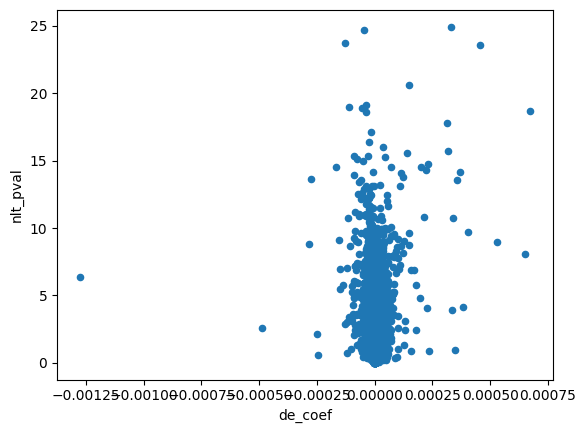

In [69]:
results_c.plot.scatter(x = 'de_coef', y = 'nlt_pval')

In [70]:
results_c.sort_values('de_coef', ascending=False).head(10)

,gene,tx,de_coef,de_se,de_pval,nlt_pval
0,ZEB2,CHG,0.000675,0.000075,2.264386e-19,18.645050
0,RABGAP1L,CHG,0.000653,0.000114,8.792517e-09,8.055887
0,CD247,CHG,0.000530,0.000087,1.019761e-09,8.991502
0,AC243829.2,CHG,0.000456,0.000045,2.862557e-24,23.543246
0,PRKCH,CHG,0.000402,0.000064,1.925640e-10,9.715425
0,NKG7,CHG,0.000381,0.000097,7.854459e-05,4.104884
0,CHSY3,CHG,0.000372,0.000048,7.602884e-15,14.119022
0,TRG-AS1,CHG,0.000357,0.000047,2.768047e-14,13.557827
0,B2M,CHG,0.000346,0.000224,1.210888e-01,0.916896
0,TOX,CHG,0.000340,0.000051,1.765547e-11,10.753121


In [42]:
results_c['qval'] = multipletests(results_c['de_pval'], method='fdr_bh', alpha=0.05)[1]

In [46]:
# if you are only intrested in dataframe that enrichr returned, please set outdir=None
# weight for factor 30, from most to least significant
gene_list = list(results_c[(results_c['qval'] < 0.05) & (results_c['de_coef'] > 0 )]['gene'])
enr = gp.enrichr(gene_list=gene_list, # or "./tests/data/gene_list.txt",
                 gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human','GO_Biological_Process_2025','Reactome_Pathways_2024'],
                 background=list(results_tf['gene']),
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

In [47]:
enr.results[enr.results['Adjusted P-value'] < 0.05].sort_values('P-value')

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,IL-2/STAT5 Signaling,2/199,0.008286,0.033464,0,0,16.741963,80.248036,LTB;IGF1R
1,MSigDB_Hallmark_2020,Complement,2/200,0.008366,0.033464,0,0,16.656566,79.677951,GZMK;SPOCK2


In [5]:
results_tf = pd.read_csv("output/memento.M.Tikari_Fulani.LPS.Ethnicity.csv", index_col=0)
results_fc = pd.read_csv("output/memento.M.Fulani_CHG.LPS.Ethnicity.csv", index_col=0)

In [6]:
results_tf.head()

,gene,tx,de_coef,de_se,de_pval
0,A1BG,Fulani,3.155660e-06,1.605758e-06,0.058670
0,A1BG-AS1,Fulani,2.641841e-07,4.871253e-07,0.615953
0,A2M,Fulani,3.907005e-06,3.051709e-05,0.902451
0,A2M-AS1,Fulani,4.617128e-08,2.850839e-07,0.900014
0,A2ML1,Fulani,-1.640004e-06,7.988838e-07,0.040907


In [101]:
results_tf = results_tf[~results_tf['gene'].str.startswith(("MT","RPL","RPS","MALAT1"))]

In [102]:
results_tf['nlt_pval'] = -np.log10(results_tf['de_pval'])

<Axes: xlabel='de_coef', ylabel='nlt_pval'>

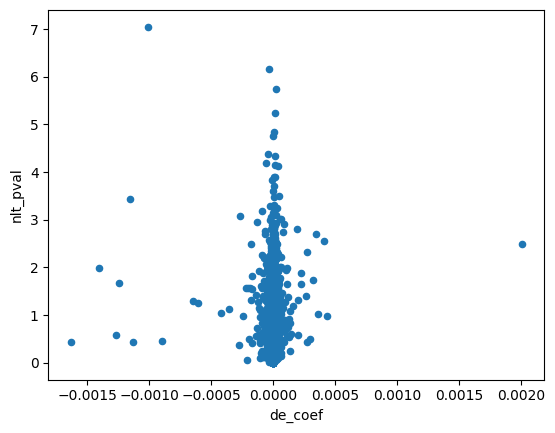

In [103]:
results_tf.plot.scatter(x = 'de_coef', y = 'nlt_pval')

In [104]:
results_tf.sort_values('de_pval').head()

,Unnamed: 0,gene,tx,de_coef,de_se,de_pval,nlt_pval
3488,0,C15orf48,Fulani,-0.001010,0.000190,8.941495e-08,7.048590
7078,0,HLA-DRB5,Fulani,-0.000036,0.000007,6.726772e-07,6.172193
14176,0,TNFRSF18,Fulani,0.000024,0.000005,1.849334e-06,5.732985
13435,0,STYXL1,Fulani,0.000012,0.000003,5.747830e-06,5.240496
5457,0,ECH1,Fulani,0.000006,0.000001,1.446019e-05,4.839826


<Axes: >

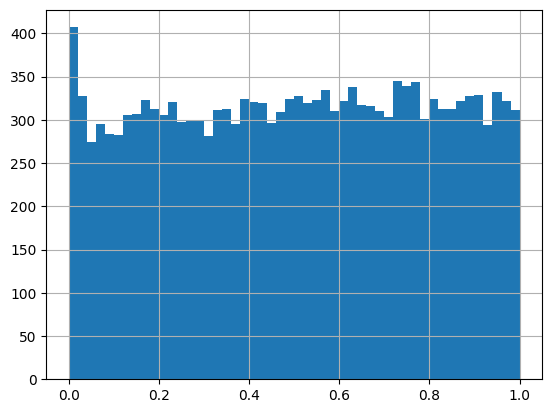

In [105]:
results_tf['de_pval'].hist(bins=50)

In [106]:
results_tf['qval'] = multipletests(results_tf['de_pval'], method='fdr_bh', alpha=0.05)[1]

In [114]:
# if you are only intrested in dataframe that enrichr returned, please set outdir=None
# weight for factor 30, from most to least significant
gene_list = list(results_tf[(results_tf['qval'] < 0.1) & (results_tf['de_coef'] > 0 )]['gene'])
enr = gp.enrichr(gene_list=gene_list, # or "./tests/data/gene_list.txt",
                 gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human','GO_Biological_Process_2025','Reactome_Pathways_2024'],
                 background=list(results_tf['gene']),
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

In [115]:
gene_list

['ECH1', 'RHOF', 'STYXL1', 'TNFRSF18']

In [112]:
enr.results.sort_values('P-value').head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
9,GO_Biological_Process_2025,Regulation of Stress Granule Assembly (GO:0062...,1/5,0.000750,0.014457,0,0,2499.125000,17982.858998,STYXL1
30,Reactome_Pathways_2024,RUNX1 and FOXP3 Control the Development of Reg...,1/10,0.001499,0.019491,0,0,1110.444444,7220.954199,TNFRSF18
10,GO_Biological_Process_2025,Regulation of Leukocyte Migration (GO:0002685),1/14,0.002099,0.014457,0,0,768.615385,4739.656184,TNFRSF18
11,GO_Biological_Process_2025,Positive Regulation of Tyrosine Phosphorylatio...,1/23,0.003446,0.014457,0,0,453.977273,2574.276639,TNFRSF18
13,GO_Biological_Process_2025,Positive Regulation of Leukocyte Migration (GO...,1/28,0.004194,0.014457,0,0,369.814815,2024.379431,TNFRSF18


In [14]:
results_tf[results_tf['qval'] < 0.05].sort_values('de_coef').tail()

,Unnamed: 0,gene,tx,de_coef,de_se,de_pval,nlt_pval,qval
9925,0,SLC35F1,Fulani,-0.000142,0.000020,1.859373e-12,11.730633,2.328307e-08
7845,0,PBXIP1,Fulani,0.000038,0.000009,7.957982e-06,5.099197,3.321662e-02
10280,0,SPOCK2,Fulani,0.000103,0.000019,6.466371e-08,7.189339,4.048595e-04


## MISC

In [ ]:
popde_dfs = []

ctypes = ['B','CD4-T','NK','M','gdT']
for ctype in ctypes:
    
    for cond in ["CTL","IFN","LPS"]:
    
        results_tf = pd.read_csv("output/memento.{}.Tikari_Fulani.{}.Ethnicity.csv".format(ctype,cond), index_col=0)
        results_tc = pd.read_csv("output/memento.{}.Tikari_CHG.{}.Ethnicity.csv".format(ctype,cond), index_col=0)
        results_fc = pd.read_csv("output/memento.{}.Fulani_CHG.{}.Ethnicity.csv".format(ctype,cond), index_col=0)

        # remove mitochondrial and ribosomal genes
        results_tf = results_tf[~results_tf['gene'].str.startswith(("MT","RPL","RPS","MALAT1"))]
        results_tc = results_tc[~results_tc['gene'].str.startswith(("MT","RPL","RPS","MALAT1"))]
        results_fc = results_fc[~results_fc['gene'].str.startswith(("MT","RPL","RPS","MALAT1"))]

        results_tf['ctype'] = ctype
        results_tc['ctype'] = ctype
        results_fc['ctype'] = ctype

        results_tf['cond'] = cond
        results_tc['cond'] = cond
        results_fc['cond'] = cond

        results_tf['pops'] = "Tikari_Fulani"
        results_tc['pops'] = "Tikari_CHG"
        results_fc['pops'] = "Fulani_CHG"

        results_tf['qval'] = multipletests(results_tf['de_pval'], method='fdr_bh', alpha=0.05)[1]
        results_tc['qval'] = multipletests(results_tc['de_pval'], method='fdr_bh', alpha=0.05)[1]
        results_fc['qval'] = multipletests(results_fc['de_pval'], method='fdr_bh', alpha=0.05)[1]

        popde_dfs.append(results_tf)
        popde_dfs.append(results_tc)
        popde_dfs.append(results_fc)